In [18]:
'''!unzip /content/Labeled_Cropped_Images_V2-20231203T230232Z-001 -d /content/Labeled_Cropped_Images_V2
'''

'!unzip /content/Labeled_Cropped_Images_V2-20231203T230232Z-001 -d /content/Labeled_Cropped_Images_V2\n'

In [19]:
'''!unzip /content/Labeled_Cropped_Masks_V2-20231203T230235Z-001 -d /content/Labeled_Cropped_Masks_V2
'''

'!unzip /content/Labeled_Cropped_Masks_V2-20231203T230235Z-001 -d /content/Labeled_Cropped_Masks_V2\n'

In [20]:
'''import shutil
folder_path = '/content/PanoramicRadiographs.zip'  # Replace with your folder path
shutil.rmtree(folder_path)'''

"import shutil\nfolder_path = '/content/PanoramicRadiographs.zip'  # Replace with your folder path\nshutil.rmtree(folder_path)"

In [21]:
'''!unzip /content/Panoramic_Radiographs.zip -d /content/
!unzip /content/Panoramic_Masks.zip -d /content/
'''

'!unzip /content/Panoramic_Radiographs.zip -d /content/\n!unzip /content/Panoramic_Masks.zip -d /content/\n'

In [22]:
pip install monai


In [23]:
import sys
import os

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float16 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [25]:
def augment_flip(file_names, root, images_dir, masks_dir):
    # Assuming idxs is a list of filenames
    for idx in idxs:
        img_path = os.path.join(root, images_dir, idx)
        mask_path = os.path.join(root, masks_dir, idx)

        img = read_image(img_path)
        mask = read_image(mask_path)

        # Apply transforms
        img = input_transform(img)
        mask = mask_transforms(mask)

        # Check for abnormalities and flip if needed
        if mask.sum() > 0:
            # Flip horizontally
            flipped_img = torch.flip(img, [2])  # Assuming dim 2 is the horizontal axis
            flipped_mask = torch.flip(mask, [2])

            # Save the flipped image and mask
            flipped_img_path = os.path.join(root, images_dir, "flipped_" + idx)
            flipped_mask_path = os.path.join(root, masks_dir, "flipped_" + idx)

            # Convert back to PIL Image to save
            flipped_img_pil = transforms.ToPILImage()(flipped_img)
            flipped_mask_pil = transforms.ToPILImage()(flipped_mask)

            flipped_img_pil.save(flipped_img_path)
            flipped_mask_pil.save(flipped_mask_path)


def visualize_flipping(img_path, mask_path, input_transform, mask_transforms):
    # Read the image and mask
    img = read_image(img_path)
    mask = read_image(mask_path)

    # Apply transforms
    img_transformed = input_transform(img)
    mask_transformed = mask_transforms(mask)

    # Check for abnormalities and flip if needed
    if mask_transformed.sum() > 0:
        # Flip horizontally
        flipped_img = torch.flip(img_transformed, [2])  # Flipping horizontally
        flipped_mask = torch.flip(mask_transformed, [2])

        # Visualization
        fig, axs = plt.subplots(2, 2, figsize=(10, 6))
        axs[0, 0].imshow(img_transformed.permute(1, 2, 0))
        axs[0, 0].set_title("Original Image")
        axs[0, 1].imshow(flipped_img.permute(1, 2, 0))
        axs[0, 1].set_title("Flipped Image")
        axs[1, 0].imshow(mask_transformed.squeeze(), cmap='gray')
        axs[1, 0].set_title("Original Mask")
        axs[1, 1].imshow(flipped_mask.squeeze(), cmap='gray')
        axs[1, 1].set_title("Flipped Mask")

        for ax in axs.flat:
            ax.axis('off')

        plt.show()
    else:
        print("No abnormalities detected, image not flipped.")


In [26]:
'''
#### horizontal flip augmentation

root = '/content/'

round_transform = transforms.Lambda(lambda x: torch.round(x))

input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0], [1]),
])

mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    round_transform,
])

images_dir="Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2"
masks_dir="Labeled_Cropped_Masks_V2/Labeled_Cropped_Masks_V2"

idxs = list(sorted(os.listdir(os.path.join(root, images_dir))))

augment_flip(idxs, root, images_dir, masks_dir)
'''

'\n#### horizontal flip augmentation\n\nroot = \'/content/\'\n\nround_transform = transforms.Lambda(lambda x: torch.round(x))\n\ninput_transform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.ToTensor(),\n    transforms.Normalize([0], [1]),\n])\n\nmask_transforms = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.ToTensor(),\n    round_transform,\n])\n\nimages_dir="Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2"\nmasks_dir="Labeled_Cropped_Masks_V2/Labeled_Cropped_Masks_V2"\n\nidxs = list(sorted(os.listdir(os.path.join(root, images_dir))))\n\naugment_flip(idxs, root, images_dir, masks_dir)\n'

In [27]:
# visualize_flipping("/content/Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2/1-11.JPG", "/content/Labeled_Cropped_Masks_V2/Labeled_Cropped_Masks_V2/1-11.JPG", input_transform, mask_transforms)

In [28]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
#from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision import transforms

class TDD(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mask_transforms=None, images_dir="Labeled_Cropped_Images_V2/", masks_dir="Labeled_Cropped_Masks_V2/"):
        self.root = root
        self.transforms = transforms
        self.mask_transforms = mask_transforms
        # load all image files, sorting them to ensure that they are aligned
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, images_dir))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, masks_dir))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.images_dir, self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks_dir, self.masks[idx])

        img = read_image(img_path)
        mask = read_image(mask_path)

        if self.transforms is not None:
            img = self.transforms(img)
        if self.mask_transforms is not None:
            mask = self.mask_transforms(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [29]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

root = '/content/'

round_transform = transforms.Lambda(lambda x: torch.round(x))

input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0], [1]),
])
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    round_transform,
])

images_dir="Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2"
masks_dir="Labeled_Cropped_Masks_V2/Labeled_Cropped_Masks_V2"

# split the TDD
dataset = TDD(root, transforms=input_transform, mask_transforms=mask_transforms, images_dir=images_dir, masks_dir=masks_dir)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [30]:
root = '/content/'

round_transform = transforms.Lambda(lambda x: torch.round(x))

input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((840, 1610)),
    transforms.Normalize([0], [1]),
])
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((840, 1610)),
    round_transform,
])

images_dir="Radiographs"
masks_dir="mask"

# split the TDD
panoramic_dataset = TDD(root, transforms=input_transform, mask_transforms=mask_transforms, images_dir=images_dir, masks_dir=masks_dir)
panoramic_dataset_size = len(panoramic_dataset)
train_size = int(0.7 * panoramic_dataset_size)
val_size = int(0.15 * panoramic_dataset_size)
test_size = panoramic_dataset_size - train_size - val_size

pano_train_dataset, pano_val_dataset, pano_test_dataset = random_split(panoramic_dataset, [train_size, val_size, test_size])


In [31]:
'''# Get class balance info from dataset
from torch.utils.data import DataLoader
import torch
import gc

# Assuming panoramic_dataset is already defined
# Consider reducing the batch size if memory issues persist
dataset_loader = DataLoader(panoramic_dataset, batch_size=32)

num_pixels = 0
num_abn = 0
num_abn_images = 0
num_images = 0
for imgs, masks in dataset_loader:
    num_images += len(masks)
    num_abn_images += (masks.squeeze().sum(dim=[1, 2]) > 0).sum().item()

    num_pixels += masks.numel()
    num_abn += masks.sum()

    # Explicit memory cleanup
    del imgs, masks
    gc.collect()
    torch.cuda.empty_cache()  # Only necessary if using GPU

print(f"Percentage of abnormal pixels in dataset: {num_abn / num_pixels}")
print(f"Percentage of abnormal images in dataset: {num_abn_images / num_images}")

# output
# Percentage of abnormal pixels in dataset: 0.002847658935934305
# Percentage of abnormal images in dataset: 0.339
'''

'# Get class balance info from dataset\nfrom torch.utils.data import DataLoader\nimport torch\nimport gc\n\n# Assuming panoramic_dataset is already defined\n# Consider reducing the batch size if memory issues persist\ndataset_loader = DataLoader(panoramic_dataset, batch_size=32)\n\nnum_pixels = 0\nnum_abn = 0\nnum_abn_images = 0\nnum_images = 0\nfor imgs, masks in dataset_loader:\n    num_images += len(masks)\n    num_abn_images += (masks.squeeze().sum(dim=[1, 2]) > 0).sum().item()\n\n    num_pixels += masks.numel()\n    num_abn += masks.sum()\n\n    # Explicit memory cleanup\n    del imgs, masks\n    gc.collect()\n    torch.cuda.empty_cache()  # Only necessary if using GPU\n\nprint(f"Percentage of abnormal pixels in dataset: {num_abn / num_pixels}")\nprint(f"Percentage of abnormal images in dataset: {num_abn_images / num_images}")\n\n# output\n# Percentage of abnormal pixels in dataset: 0.002847658935934305\n# Percentage of abnormal images in dataset: 0.339\n'

In [32]:
'''# Get class balance info from dataset
from torch.utils.data import DataLoader
import torch
import gc

# Assuming panoramic_dataset is already defined
# Consider reducing the batch size if memory issues persist
dataset_loader = DataLoader(dataset, batch_size=32)

num_pixels = 0
num_abn = 0
num_abn_images = 0
num_images = 0
for imgs, masks in dataset_loader:
    num_images += len(masks)
    num_abn_images += (masks.squeeze().sum(dim=[1, 2]) > 0).sum().item()

    num_pixels += masks.numel()
    num_abn += masks.sum()

    # Explicit memory cleanup
    del imgs, masks
    gc.collect()
    torch.cuda.empty_cache()  # Only necessary if using GPU

print(f"Percentage of abnormal pixels in dataset: {num_abn / num_pixels}")
print(f"Percentage of abnormal images in dataset: {num_abn_images / num_images}")

# output
# Percentage of abnormal pixels in dataset: 0.008700688369572163
# Percentage of abnormal images in dataset: 0.06480997536026283
'''

'# Get class balance info from dataset\nfrom torch.utils.data import DataLoader\nimport torch\nimport gc\n\n# Assuming panoramic_dataset is already defined\n# Consider reducing the batch size if memory issues persist\ndataset_loader = DataLoader(dataset, batch_size=32)\n\nnum_pixels = 0\nnum_abn = 0\nnum_abn_images = 0\nnum_images = 0\nfor imgs, masks in dataset_loader:\n    num_images += len(masks)\n    num_abn_images += (masks.squeeze().sum(dim=[1, 2]) > 0).sum().item()\n\n    num_pixels += masks.numel()\n    num_abn += masks.sum()\n\n    # Explicit memory cleanup\n    del imgs, masks\n    gc.collect()\n    torch.cuda.empty_cache()  # Only necessary if using GPU\n\nprint(f"Percentage of abnormal pixels in dataset: {num_abn / num_pixels}")\nprint(f"Percentage of abnormal images in dataset: {num_abn_images / num_images}")\n\n# output\n# Percentage of abnormal pixels in dataset: 0.008700688369572163\n# Percentage of abnormal images in dataset: 0.06480997536026283\n'

In [33]:
import matplotlib.pyplot as plt

def imshow_grayscale(tensor):
    if tensor.ndim == 3 and tensor.shape[0] == 1:
        # Remove the channel dimension and convert to numpy
        image = tensor.squeeze(0).cpu().numpy()
    else:
        raise ValueError("The input tensor should be of shape (1, H, W)")

    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()


In [34]:
class DeepUpsamplingNet(nn.Module):
    def __init__(self, num_channels_list=[384, 256, 128, 64]):
        super(DeepUpsamplingNet, self).__init__()

        self.num_channels = num_channels_list
        self.ReLU = nn.ReLU()

        # First Upsample to an intermediate size, e.g., (14, 4)
        self.upsample1 = nn.Upsample(size=(14, 4), mode='bilinear', align_corners=False)
        self.conv1 = nn.Conv2d(num_channels_list[0], num_channels_list[1], kernel_size=3, stride=1, padding=1)

        # Second Upsample to a larger size, e.g., (56, 16)
        self.upsample2 = nn.Upsample(size=(56, 16), mode='bilinear', align_corners=False)
        self.conv2 = nn.Conv2d(num_channels_list[1], num_channels_list[2], kernel_size=3, stride=1, padding=1)

        # Final Upsample to target size (98, 28)
        self.upsample3 = nn.Upsample(size=(98, 28), mode='bilinear', align_corners=False)
        self.conv3 = nn.Conv2d(num_channels_list[2], num_channels_list[3], kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.upsample1(x)
        x = self.ReLU(self.conv1(x))
        x = self.upsample2(x)
        x = self.ReLU(self.conv2(x))
        x = self.upsample3(x)
        x = self.ReLU(self.conv3(x))
        return x

class OneLayerUpsamplingNet(nn.Module):
    def __init__(self, num_channels_list=[384, 64]):
        super(OneLayerUpsamplingNet, self).__init__()
        self.num_channels = num_channels_list
        self.ReLU = nn.ReLU()
        self.transposed_conv = nn.ConvTranspose2d(num_channels_list[0], num_channels_list[1], kernel_size=(14,14), stride=(14,14))

    def forward(self, x):
        x = self.ReLU(self.transposed_conv(x))
        return x

In [35]:
# veryify upsampling net dimensions
tens = torch.randn((64, 384, 7, 2))
model = DeepUpsamplingNet()
assert model(tens).shape == torch.Size([64, 64, 98, 28])
model = OneLayerUpsamplingNet()
assert model(tens).shape == torch.Size([64, 64, 98, 28])

In [36]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision

class UNET(nn.Module):
    def __init__(self, upsampling_net, out_channels=[32, 64, 3]):
        super(UNET, self).__init__()

        self.out_channels = out_channels

        self.ReLU = nn.ReLU()

        ### ENCODER ###
        self.conv1 = nn.Conv2d(1, self.out_channels[0], kernel_size=(22, 15), stride=1) # h_out, w_out = (119, 42)
        self.ln1 = nn.LayerNorm([self.out_channels[0], 119, 42])
        self.conv2 = nn.Conv2d(self.out_channels[0], self.out_channels[1], kernel_size=(22, 15), stride=1) # h_out, w_out = 64 x (98, 28)
        self.ln2 = nn.LayerNorm([self.out_channels[1], 98, 28])
        self.unit_conv = nn.Conv2d(self.out_channels[1], self.out_channels[2], kernel_size=1) # h_out, w_out = 3 x (98, 28)
        self.ln3 = nn.LayerNorm([self.out_channels[2], 98, 28])

        ### ViT ###
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
        # freeze ViT weights
        for param in self.backbone.parameters():
            param.requires_grad = False

        ### Upsampling Net ###
        self.upsampling_net = upsampling_net
        upsample_out_channels = self.upsampling_net.num_channels[-1] # defaults to 64

        ### DECODER ###
        # Note: naming convention is chosen so that self.conv1 is paired with self.dec_conv1, etc.

        # c, h, w = (upsample_out_channels + 64, 98, 28)
        self.dec_conv2 = nn.Conv2d(upsample_out_channels + self.out_channels[1], self.out_channels[1], kernel_size=(5, 5), padding='same')
        # c, h, w = (64, 98, 28)
        self.dec_conv2_ln = nn.LayerNorm([self.out_channels[1], 98, 28])
        self.dec_tconv2 = nn.ConvTranspose2d(self.out_channels[1], self.out_channels[0], kernel_size=(22, 15), stride=1)
        # c, h, w = (32, 119, 42)

        # c, h, w = (32 + 32, 119, 42)
        self.dec_conv1 = nn.Conv2d(self.out_channels[0] + self.out_channels[0], self.out_channels[0], kernel_size=(5, 5), padding='same')
        # c, h, w = (32, 119, 42)
        self.dec_conv1_ln = nn.LayerNorm([self.out_channels[0], 119, 42])
        self.dec_tconv1 = nn.ConvTranspose2d(self.out_channels[0], 1, kernel_size=(22, 15), stride=1)
        # c, h, w = (1, 140, 56)

        # c, h, w = (1 + 1, 140, 56)
        self.dec_unit_conv = nn.Conv2d(2, 1, kernel_size=1) # h_out, w_out = 1 x (140, 56)
        # c, h, w = (1, 140, 56)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # assume x is shape (batch size, 1, 140, 56)
        x = x[:, :1, :, :]

        bs = x.shape[0]
        out1 = self.conv1(x)
        out1_layer_relu = self.ReLU(self.ln1(out1)) # h_out, w_out = (119, 42)

        out2 = self.conv2(out1_layer_relu)
        out2_layer_relu = self.ReLU(self.ln2(out2)) # h_out, w_out = (98, 28)

        out3 = self.unit_conv(out2_layer_relu)
        out3_layer_relu = self.ReLU(self.ln3(out3)) # h_out, w_out = (98, 28)

        # output shape is (batch size, C, 98, 28)
        batch_size, C, height, width = out3_layer_relu.size()
        # assert (height, width) == (98, 28)
        # need to duplicate layers to get (batch size, 3, 98, 28)
        if C == 1:
            out3_layer_relu = out3_layer_relu.repeat(1, 3, 1, 1)

        VIT_out = self.backbone.forward_features(out3_layer_relu)
        VIT_out = VIT_out["x_norm_patchtokens"]

        # then permute and reshape this into (batch_size, 384, 7, 2)
        VIT_out = VIT_out.permute((0, 2, 1)).reshape(-1, 384, 7, 2)

        # upsample ViT output to spatial resolution of ViT input image
        upsampled_vit_output = self.upsampling_net(VIT_out)  # h_out, w_out = (98, 28)

        upsample_conv2 = self.dec_conv2(torch.cat((out2_layer_relu, upsampled_vit_output), dim=1))
        upsample_conv2_ln_relu = self.ReLU(self.dec_conv2_ln(upsample_conv2))
        upsample_tconv2 = self.dec_tconv2(upsample_conv2_ln_relu) # h_out, w_out = (119, 42)

        upsample_conv1 = self.dec_conv1(torch.cat((out1_layer_relu, upsample_tconv2), dim=1))
        upsample_conv1_ln_relu = self.ReLU(self.dec_conv1_ln(upsample_conv1))
        upsample_tconv1 = self.dec_tconv1(upsample_conv1_ln_relu) # h_out, w_out = (140, 56)

        out_logits = self.dec_unit_conv(torch.cat((x, upsample_tconv1), dim=1))
        out_probs = self.sigmoid(out_logits)
        return out_probs

In [37]:
'''backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
tensor = torch.randn(1, 3, 840, 1610).to(device)
backbone.forward_features(tensor)'''

"backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)\ntensor = torch.randn(1, 3, 840, 1610).to(device)\nbackbone.forward_features(tensor)"

In [38]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, panoramic=False, use_patches=True):
        super(LinearModel, self).__init__()
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.h = 140 if not panoramic else 840
        self.w = 56 if not panoramic else 1610

        self.use_patches = use_patches
        if self.use_patches:
            self.num_patches = (self.h // 14) * (self.w // 14)
        else:
            self.num_patches = 1

        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_patches * 384, self.h * self.w),
            nn.Sigmoid(),
        ).to(device)

    def forward(self, x):
        if x.shape[1] != 3:
            x = x.repeat(1, 3, 1, 1).to(device)
        if self.use_patches:
            x = self.backbone.forward_features(x)["x_norm_patchtokens"]
        else:
            x = self.backbone(x)
        x = self.decoder(x).view(-1, 1, self.h, self.w)

        return x

In [39]:
# Loss Functions
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.97, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class WeightedBCELoss(nn.Module):
    def __init__(self, weight_for_normal, weight_for_abnormal):
        super(WeightedBCELoss, self).__init__()
        self.weight_for_normal = weight_for_normal
        self.weight_for_abnormal = weight_for_abnormal

    def forward(self, inputs, targets):
        # inputs are probabilities [0, 1] from sigmoid
        # targets are ground truth labels (0 or 1)

        # Calculate the standard BCELoss
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')

        # Apply weights
        weights = targets * self.weight_for_abnormal + (1 - targets) * self.weight_for_normal
        weighted_loss = weights * bce_loss

        return torch.mean(weighted_loss)

In [40]:
# Metrics

def calculate_pixel_accuracy(preds_binary, target):
    true_positives = (preds_binary * target).sum()
    true_negatives = ((1 - preds_binary) * (1 - target)).sum()
    total_pixels = target.numel()

    pixel_accuracy = (true_positives + true_negatives) / total_pixels
    return pixel_accuracy.item()

def dice_coefficient(preds_binary, target, smooth=1e-6):
    intersection = (preds_binary * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (preds_binary.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    dice = dice.mean(dim=0)
    return dice.item()

def jaccard_index(preds_binary, target, smooth=1e-6):
    intersection = (preds_binary * target).sum(dim=2).sum(dim=2)
    union = preds_binary.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection

    jaccard = (intersection + smooth) / (union + smooth)
    jaccard = jaccard.mean(dim=0)
    return jaccard.item()

def calculate_precision_recall_f1(preds_binary, labels):
    true_positives = torch.sum((preds_binary == 1) & (labels == 1)).item()
    false_positives = torch.sum((preds_binary == 1) & (labels == 0)).item()
    false_negatives = torch.sum((preds_binary == 0) & (labels == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def binary_classification_accuracy(preds_binary, labels, threshold=0.1):
    preds_binary = preds_binary.round()

    # Correct the normalization by the number of elements per image
    pred_class = preds_binary.view(preds_binary.size(0), -1).sum(dim=1) / preds_binary.view(preds_binary.size(0), -1).shape[1] > threshold
    label_class = labels.view(labels.size(0), -1).sum(dim=1) / labels.view(labels.size(0), -1).shape[1] > threshold

    accuracy = torch.mean((pred_class == label_class).float())
    return accuracy



In [41]:
def clip_lists_to_shortest(*lists):
    # Find the length of the shortest list
    shortest_length = min(len(lst) for lst in lists)

    # Clip each list to the length of the shortest list
    clipped_lists = [lst[:shortest_length] for lst in lists]

    return clipped_lists

In [60]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

class Solver:
    def __init__(self, model, optimizer, loss_function, train_loader, val_loader, device, verbose=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.verbose = verbose

        self.train_losses, self.train_accs = [], []
        self.val_losses, self.val_accs, self.val_dice_scores, self.val_jaccard_scores = [], [], [], []
        self.val_precision, self.val_recall, self.val_f1 = [], [], []
        self.val_percent_abnormal_pixels = []
        self.xs = []

        self.test_predictions = None
        self.test_preds_binary = None
        self.test_labels = None

        self.test_loss = None
        self.test_precision, self.test_recall, self.test_f1 = None, None, None
        self.test_dice = None
        self.test_jaccard = None
        self.test_acc = None
        self.test_percent_abn_pixels = None
        self.test_classification_accuracy = None

        self.loss_function = loss_function
        self.optimizer = optimizer
        self.writer = SummaryWriter()

    def train(self, epochs, print_every=None):
        interrupt = False # tracks for keyboard interrupt

        # set model to evaluate and print performance 10x per epoch
        if print_every is None:
            print_every = len(self.train_loader) // 5

        iteration = 0
        avg_train_loss = 0
        avg_train_acc = 0

        try:
            for epoch in range(epochs):
                if not self.verbose:
                    print(f"Epoch {epoch}")

                self.model.train()

                for images, masks in self.train_loader:
                    images, masks = images.to(self.device), masks.to(self.device)

                    preds = self.model(images)
                    loss = self.loss_function(preds, masks)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    avg_train_loss += loss.item()

                    preds_binary = (preds > 0.5).float()
                    avg_train_acc += calculate_pixel_accuracy(preds_binary, masks)

                    del images, masks, preds, preds_binary
                    torch.cuda.empty_cache()

                    if iteration % print_every == 0:
                        avg_train_loss /= print_every
                        avg_train_acc /= print_every

                        if self.verbose:
                            print(f"\nEpoch {epoch} | Iteration {iteration}")
                            print(f"Training Loss = {avg_train_loss}")
                            print(f"Training Acc = {avg_train_acc}")

                        self.xs.append(iteration)
                        self.train_accs.append(avg_train_acc)
                        self.train_losses.append(avg_train_loss)
                        avg_train_loss = 0
                        avg_train_acc = 0

                        # evaluate the model on the validation set
                        self.evaluate()

                    iteration += 1

                # visualize metrics at the end of each epoch
                if self.verbose:
                    self.plot_metrics()

        except KeyboardInterrupt:
            interrupt = True
            print("Training interrupted by user.")
            torch.save(self.model.state_dict(), 'best_linear_model.pth')

            # clip lists of metrics to be the same length
            self.val_percent_abnormal_pixels, self.train_losses, self.train_accs, self.val_losses, self.val_accs, self.val_dice_scores, self.val_jaccard_scores, self.val_precision, self.val_recall, self.val_f1, self.val_percent_abnormal_pixels, self.xs = clip_lists_to_shortest(self.val_percent_abnormal_pixels, self.train_losses, self.train_accs, self.val_losses, self.val_accs, self.val_dice_scores, self.val_jaccard_scores, self.val_precision, self.val_recall, self.val_f1, self.val_percent_abnormal_pixels, self.xs)
            self.val_predictions, self.val_preds_binary, self.val_labels = clip_lists_to_shortest(self.val_predictions, self.val_preds_binary, self.val_labels)

        finally:
            if not self.verbose:
                self.plot_metrics()
            return interrupt


    def evaluate(self):
        self.model.eval()

        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for val_images, val_masks in self.val_loader:
                val_images, val_masks = val_images.to(self.device), val_masks.to(self.device)
                val_preds = self.model(val_images)

                # accumulate results
                val_predictions.append(val_preds.cpu())
                val_labels.append(val_masks.cpu())

                del val_images, val_masks, val_preds
                torch.cuda.empty_cache()
                gc.collect()

        val_predictions = torch.cat(val_predictions, dim=0)
        val_labels = torch.cat(val_labels, dim=0)

        loss = self.loss_function(val_predictions, val_labels).item()
        val_preds_binary = (val_predictions > 0.5).float()
        precision, recall, f1 = calculate_precision_recall_f1(val_preds_binary, val_labels)
        dice = dice_coefficient(val_preds_binary, val_labels)
        jaccard = jaccard_index(val_preds_binary, val_labels)
        acc = calculate_pixel_accuracy(val_preds_binary, val_labels)
        percent_abn_pixels = val_preds_binary.sum().item() / len(val_preds_binary.flatten())

        # Append the averaged metrics
        self.val_precision.append(precision)
        self.val_recall.append(recall)
        self.val_f1.append(f1)
        self.val_losses.append(loss)
        self.val_accs.append(acc)
        self.val_dice_scores.append(dice)
        self.val_jaccard_scores.append(jaccard)
        self.val_percent_abnormal_pixels.append(percent_abn_pixels)

        if self.verbose:
            print(f"Val Loss = {loss}")
            print(f"Val Accuracy = {acc}")


    def test(self, test_loader):
        self.model.eval()

        test_predictions = []
        test_labels = []

        with torch.no_grad():
            for test_images, test_masks in test_loader:
                test_images, test_masks = test_images.to(self.device), test_masks.to(self.device)
                test_preds = self.model(test_images)

                # accumulate results
                test_predictions.append(test_preds.cpu())
                test_labels.append(test_masks.cpu())

                # clean up memory
                del test_images, test_masks, test_preds
                torch.cuda.empty_cache()
                gc.collect()

        self.test_predictions = torch.cat(test_predictions, dim=0)
        self.test_labels = torch.cat(test_labels, dim=0)

        self.test_loss = self.loss_function(self.test_predictions, self.test_labels).item()
        self.test_preds_binary = (self.test_predictions > 0.5).float()
        self.test_precision, self.test_recall, self.test_f1 = calculate_precision_recall_f1(self.test_preds_binary, self.test_labels)
        self.test_dice = dice_coefficient(self.test_preds_binary, self.test_labels)
        self.test_jaccard = jaccard_index(self.test_preds_binary, self.test_labels)
        self.test_acc = calculate_pixel_accuracy(self.test_preds_binary, self.test_labels)
        self.test_percent_abn_pixels = self.test_preds_binary.sum().item() / len(self.test_preds_binary.flatten())
        self.test_classification_accuracy = binary_classification_accuracy(self.test_preds_binary, self.test_labels)

        print(f"\nTest Metrics:")
        print(f"Loss: {self.test_loss}")
        print(f"Accuracy: {self.test_acc}")
        print(f"Dice Score: {self.test_dice}")
        print(f"Jaccard Index: {self.test_jaccard}")
        print(f"Precision: {self.test_precision}")
        print(f"Recall: {self.test_recall}")
        print(f"F1: {self.test_f1}")
        print(f"Percentage of pixels masked as abnormal: {self.test_percent_abn_pixels}")
        print(f"Binary classification accuracy: {self.test_classification_accuracy}")

    def plot_classification_accuracy(self, thresholds=np.geomspace(1e-4, 1, num=10)):
        # Assuming solver and solver.classification_accuracy are already defined

        # Calculate accuracy at each threshold
        accuracies = [binary_classification_accuracy(self.test_preds_binary, self.test_labels, threshold) for threshold in thresholds]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, marker='o', linestyle='-')
        plt.title('Classification Accuracy at Different Thresholds')
        plt.xlabel('Threshold')
        plt.ylabel('Accuracy')
        plt.xscale('log')  # Set the x-axis to a logarithmic scale
        plt.grid(True)
        plt.show()


    def visualize_masks(self, mode='abnormal', num_images=10, pred_threshold=0.5, abn_percent_threshold=0.05):
        # get indices of normal or abnormal samples
        idxs = []
        # Assuming self.test_labels is a PyTorch tensor
        labels_flat = self.test_labels.view(self.test_labels.size(0), -1)  # Flatten the labels while keeping the batch dimension
        labels_sum = labels_flat.sum(dim=1)  # Sum over the flattened dimensions
        # Calculate the percentage of abnormal pixels for each image
        labels_abn_percent = labels_sum.float() / labels_flat.size(1)

        if mode == 'abnormal':
            # Find indices where the percentage of abnormal pixels is greater than the threshold
            idxs = torch.where(labels_abn_percent > abn_percent_threshold)[0]
        elif mode == 'normal':
            # Find indices where there are no abnormal pixels
            idxs = torch.where(labels_sum == 0)[0]

        # Convert idxs to a list, if needed
        idxs = idxs.tolist()

        idxs = idxs[:num_images]

        fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

        for i, idx in enumerate(idxs):
            # Retrieve predicted and target masks
            pred_mask = (self.test_predictions[idx] > pred_threshold).int().squeeze()
            target_mask = (self.test_labels[idx] > 0.5).int().squeeze()

            # Check if we have more than one image to plot
            if num_images > 1:
                ax_pred = axs[i, 0]
                ax_target = axs[i, 1]
            else:
                ax_pred = axs[0]
                ax_target = axs[1]

            # Plot predicted mask
            ax_pred.imshow(pred_mask.cpu().numpy(), cmap='gray')
            ax_pred.set_title(f'Predicted Mask for index {idx}')
            ax_pred.axis('off')

            # Plot target mask
            ax_target.imshow(target_mask.cpu().numpy(), cmap='gray')
            ax_target.set_title(f'Target Mask for index {idx}')
            ax_target.axis('off')

        plt.tight_layout()
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize=(10, 15))

        plt.subplot(3, 2, 1)
        plt.plot(self.xs, self.train_losses, label='Train Loss')
        plt.plot(self.xs, self.val_losses, label='Val Loss')
        plt.title('Training & Validation Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 2, 2)
        plt.plot(self.xs, self.train_accs, label='Train Accuracy')
        plt.plot(self.xs, self.val_accs, label='Val Accuracy')
        plt.ylim(0, 1)
        plt.title('Training & Validation Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(3, 2, 3)
        plt.plot(self.xs, self.val_dice_scores, label='Dice Score')
        plt.plot(self.xs, self.val_jaccard_scores, label='Jaccard Index')
        plt.title('Validation Dice & Jaccard Scores')
        plt.xlabel('Iteration')
        plt.legend()

        plt.subplot(3, 2, 4)
        plt.plot(self.xs, self.val_percent_abnormal_pixels)
        plt.ylim(0, 1)
        plt.title('Percentage of pixels masked as abnormal during val')
        plt.xlabel('Iteration')

        plt.subplot(3, 2, 5)
        plt.plot(self.xs, self.val_precision, label='Precision')
        plt.plot(self.xs, self.val_recall, label='Recall')
        plt.title('Validation Precision & Recall')
        plt.xlabel('Iteration')
        plt.legend()

        plt.subplot(3, 2, 6)
        plt.plot(self.xs, self.val_f1)
        plt.title('Validation F1 Scores')
        plt.xlabel('Iteration')

        plt.tight_layout(pad=3.0)

        plt.show()

In [43]:
'''train_loader = DataLoader(pano_train_dataset, batch_size=32, shuffle=True)
imgs, masks = next(iter(train_loader))'''

'train_loader = DataLoader(pano_train_dataset, batch_size=32, shuffle=True)\nimgs, masks = next(iter(train_loader))'

In [44]:
torch.cuda.empty_cache()

In [45]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
import os
import torch
import ast
from torch.utils.data import DataLoader
import torch.optim as optim

def load_models(saved_models_path = '/content/saved_models/'):
    solver_dict = {}

    # Iterate over each saved model file
    for model_path in os.listdir(saved_models_path):
        if model_path.endswith('.pth'):
            model_state = torch.load(os.path.join(saved_models_path, model_path))
            model_config = model_path.split("_model_state.pth")[0]
            print(model_config)

            lr = float(model_config.split("lr=")[1].split(",")[0])
            abn_weight = float(model_config.split("abn_weight=")[1].split(",")[0])

            out_channels = None
            if 'LinearModel' not in model_config:
                batch_size = 256

                if 'OneLayer' in model_config:
                    upsampling_net = OneLayerUpsamplingNet()
                    batch_size = 256
                else:
                    upsampling_net = DeepUpsamplingNet()

                if 'out_channels=' in model_config:
                    out_channels = ast.literal_eval(model_config.split('out_channels=')[1].split("]")[0] + "]")
                    model = UNET(upsampling_net, out_channels)
                else:
                    model = UNET(upsampling_net)
            else:
                batch_size = 1024
                if out_channels:
                    model = LinearModel()
                else:
                    model = LinearModel(use_patches=False)

            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            model.load_state_dict(model_state)

            optimizer = optim.Adam(model.parameters(), lr)
            loss_function = WeightedBCELoss(weight_for_normal=(1-abn_weight), weight_for_abnormal=abn_weight)
            solver = Solver(model=model, optimizer=optimizer, loss_function=loss_function, train_loader=None, val_loader=None, device=device)
            solver_dict[model_config] = solver

    return solver_dict


In [61]:
import os
import torch
import ast
from torch.utils.data import DataLoader
import torch.optim as optim

solver_dict = {}
saved_models_path = [
    '/content/saved_models/lr=0.001, abn_weight=0.98, model=LinearModel, out_channels=None, upsampling_net=None_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.98, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.982, model=LinearModel, out_channels=None, upsampling_net=None_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.982, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.984, model=LinearModel, out_channels=None, upsampling_net=None_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.984, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.986, model=LinearModel, out_channels=None, upsampling_net=None_model_state.pth',
    '/content/saved_models/lr=0.001, abn_weight=0.986, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer_model_state.pth',
    #'/content/saved_models/lr=0.001, abn_weight=0.988, model=LinearModel, out_channels=None, upsampling_net=None_model_state.pth',
    #'/content/saved_models/lr=0.001, abn_weight=0.988, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer_model_state.pth',
]

# Iterate over each saved model file
for model_path in saved_models_path:
    if model_path.endswith('.pth'):
        model_state = torch.load(model_path)
        model_config = model_path.split("_model_state.pth")[0]
        print(model_config)

        lr = float(model_config.split("lr=")[1].split(",")[0])
        abn_weight = float(model_config.split("abn_weight=")[1].split(",")[0])

        out_channels = None
        if 'LinearModel' not in model_config:
            batch_size = 256

            if 'OneLayer' in model_config:
                upsampling_net = OneLayerUpsamplingNet()
                batch_size = 256
            else:
                upsampling_net = DeepUpsamplingNet()

            if 'out_channels=' in model_config:
                out_channels = ast.literal_eval(model_config.split('out_channels=')[1].split("]")[0] + "]")
                model = UNET(upsampling_net, out_channels)
            else:
                model = UNET(upsampling_net)
        else:
            batch_size = 1024
            model = LinearModel()


        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.load_state_dict(model_state)

        optimizer = optim.Adam(model.parameters(), lr)
        loss_function = WeightedBCELoss(weight_for_normal=(1-abn_weight), weight_for_abnormal=abn_weight)
        solver = Solver(model=model, optimizer=optimizer, loss_function=loss_function, train_loader=None, val_loader=None, device=device)
        solver_dict[model_config] = solver


/content/saved_models/lr=0.001, abn_weight=0.98, model=LinearModel, out_channels=None, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.98, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.982, model=LinearModel, out_channels=None, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.982, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.984, model=LinearModel, out_channels=None, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.984, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.986, model=LinearModel, out_channels=None, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.986, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


/content/saved_models/lr=0.001, abn_weight=0.98, model=LinearModel, out_channels=None, upsampling_net=None

Test Metrics:
Loss: 0.026085279881954193
Accuracy: 0.939609169960022
Dice Score: 0.04207953065633774
Jaccard Index: 0.033956702798604965
Precision: 0.09495700407801506
Recall: 0.6911279187338956
F1: 0.16697289235083698
Percentage of pixels masked as abnormal: 0.06373837790901382
Binary classification accuracy: 0.8215973973274231


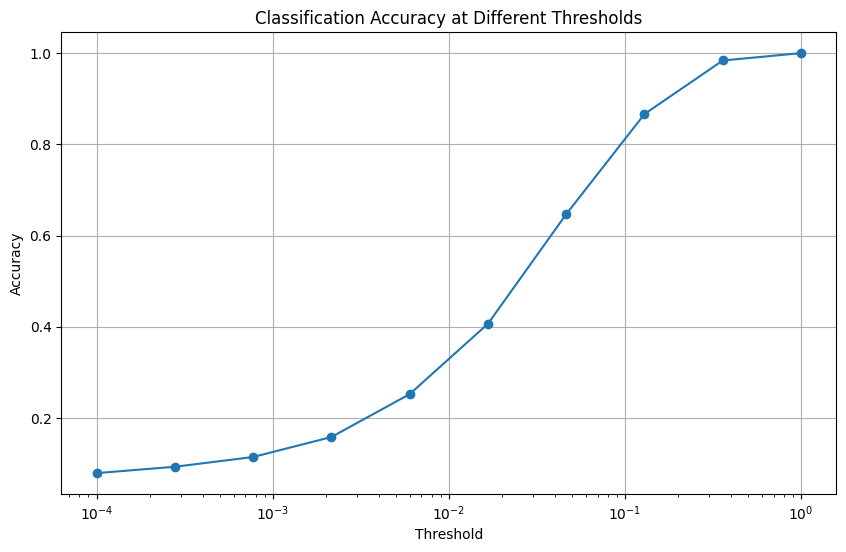

/content/saved_models/lr=0.001, abn_weight=0.98, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer

Test Metrics:
Loss: 0.01561054214835167
Accuracy: 0.9283339977264404
Dice Score: 0.2493613064289093
Jaccard Index: 0.24559620022773743
Precision: 0.029093645885400532
Recall: 0.2219089416633748
F1: 0.051442817626759806
Percentage of pixels masked as abnormal: 0.06679534964022932
Binary classification accuracy: 0.7034088373184204


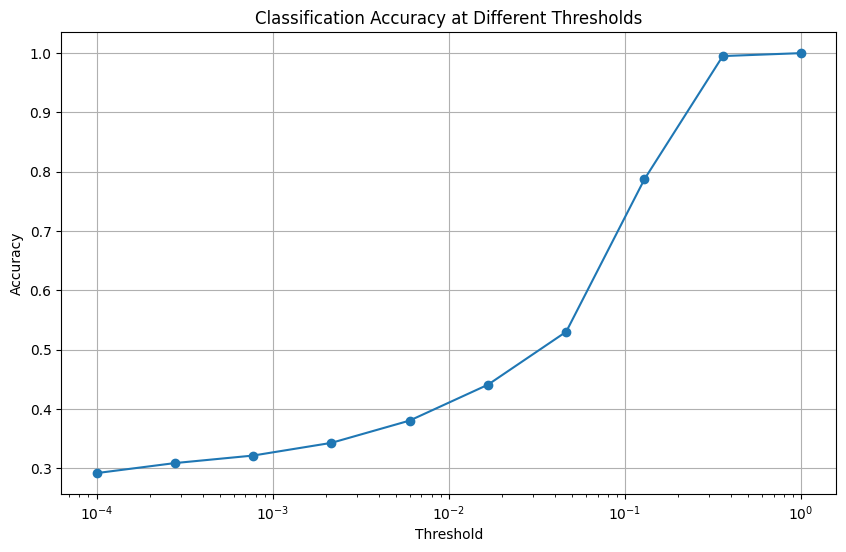

/content/saved_models/lr=0.001, abn_weight=0.982, model=LinearModel, out_channels=None, upsampling_net=None

Test Metrics:
Loss: 0.01866082474589348
Accuracy: 0.9243254661560059
Dice Score: 0.060224637389183044
Jaccard Index: 0.05225025862455368
Precision: 0.08689222406522912
Recall: 0.8036298666705324
F1: 0.15682752211694664
Percentage of pixels masked as abnormal: 0.08099248594685449
Binary classification accuracy: 0.7399850487709045


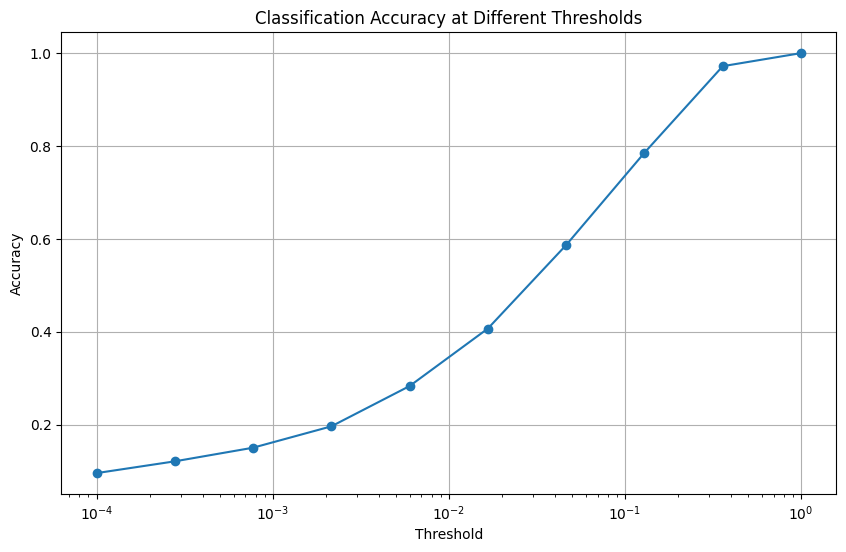

/content/saved_models/lr=0.001, abn_weight=0.982, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer

Test Metrics:
Loss: 0.013525668531656265
Accuracy: 0.7727867960929871
Dice Score: 0.06800145655870438
Jaccard Index: 0.061945658177137375
Precision: 0.02712719666444725
Recall: 0.7155251455969384
F1: 0.05227261866261978
Percentage of pixels masked as abnormal: 0.2309880745032524
Binary classification accuracy: 0.33913910388946533


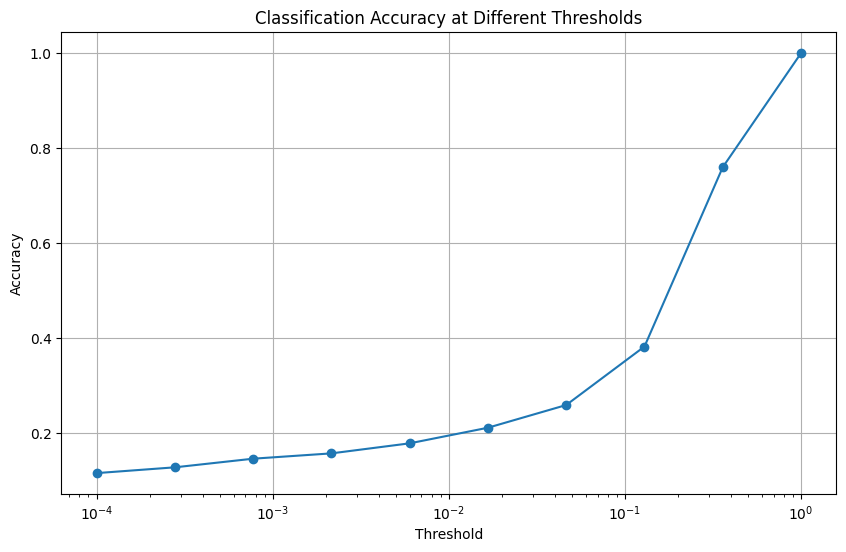

/content/saved_models/lr=0.001, abn_weight=0.984, model=LinearModel, out_channels=None, upsampling_net=None

Test Metrics:
Loss: 0.013468352146446705
Accuracy: 0.9292014837265015
Dice Score: 0.047853872179985046
Jaccard Index: 0.0395830012857914
Precision: 0.09124478771777
Recall: 0.7907245599475234
F1: 0.16360998215330166
Percentage of pixels masked as abnormal: 0.07589038165651929
Binary classification accuracy: 0.7695944309234619


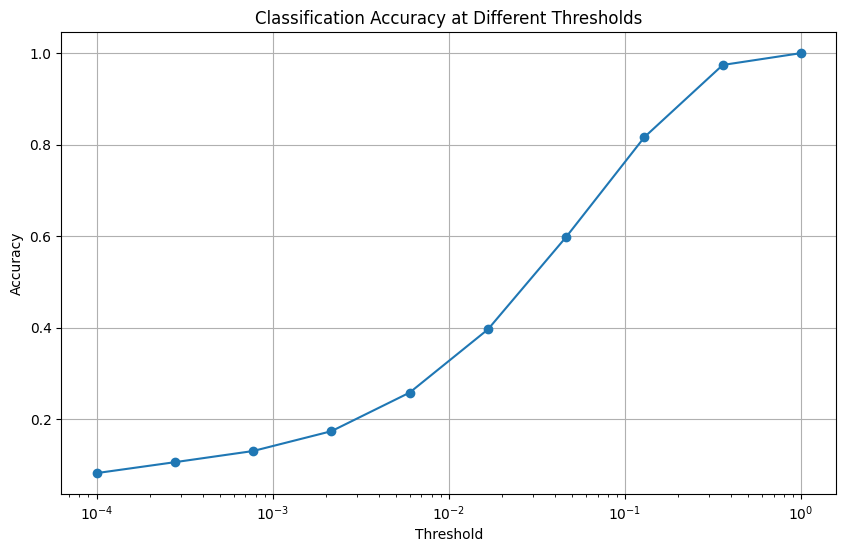

/content/saved_models/lr=0.001, abn_weight=0.984, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer

Test Metrics:
Loss: 0.0146861020475626
Accuracy: 0.9392457008361816
Dice Score: 0.012401850894093513
Jaccard Index: 0.007992945611476898
Precision: 0.03699627985526365
Recall: 0.23722062964560237
F1: 0.06400977108074979
Percentage of pixels masked as abnormal: 0.05615183744560277
Binary classification accuracy: 0.8576760292053223


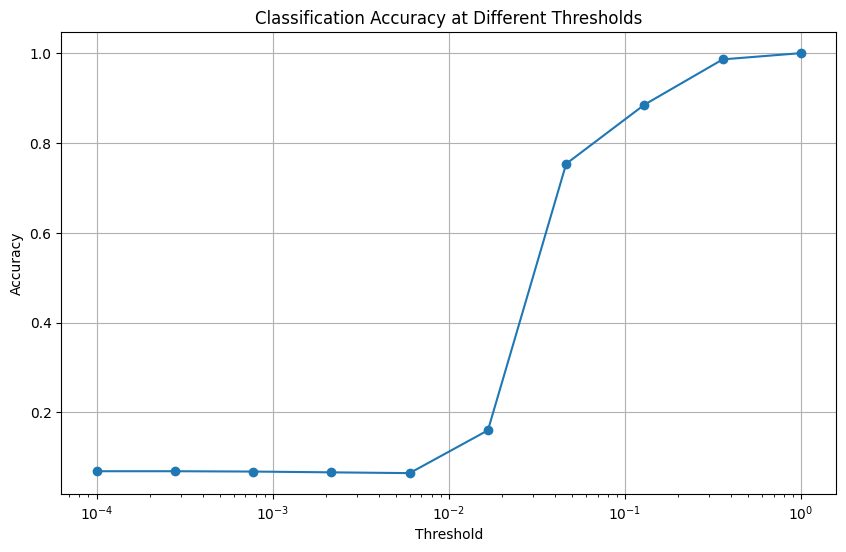

/content/saved_models/lr=0.001, abn_weight=0.986, model=LinearModel, out_channels=None, upsampling_net=None

Test Metrics:
Loss: 0.010041777975857258
Accuracy: 0.8833978176116943
Dice Score: 0.0365336649119854
Jaccard Index: 0.02850620076060295
Precision: 0.06125997244706001
Recall: 0.8597449380827955
F1: 0.11437061977910934
Percentage of pixels masked as abnormal: 0.12290297743879836
Binary classification accuracy: 0.5847225785255432


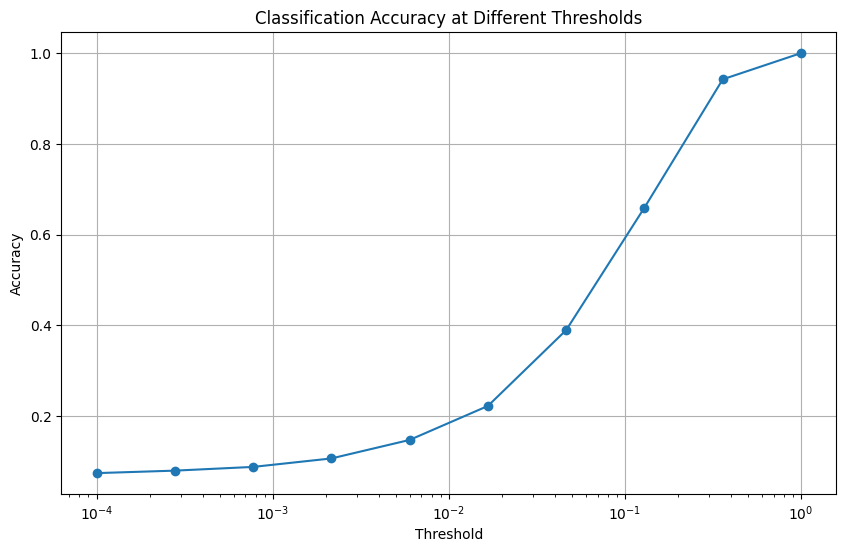

/content/saved_models/lr=0.001, abn_weight=0.986, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer

Test Metrics:
Loss: 0.012933830730617046
Accuracy: 0.9444341063499451
Dice Score: 0.12890662252902985
Jaccard Index: 0.12545165419578552
Precision: 0.05283860456119522
Recall: 0.3158012995908427
F1: 0.09053007990209372
Percentage of pixels masked as abnormal: 0.052339810644337355
Binary classification accuracy: 0.8631500601768494


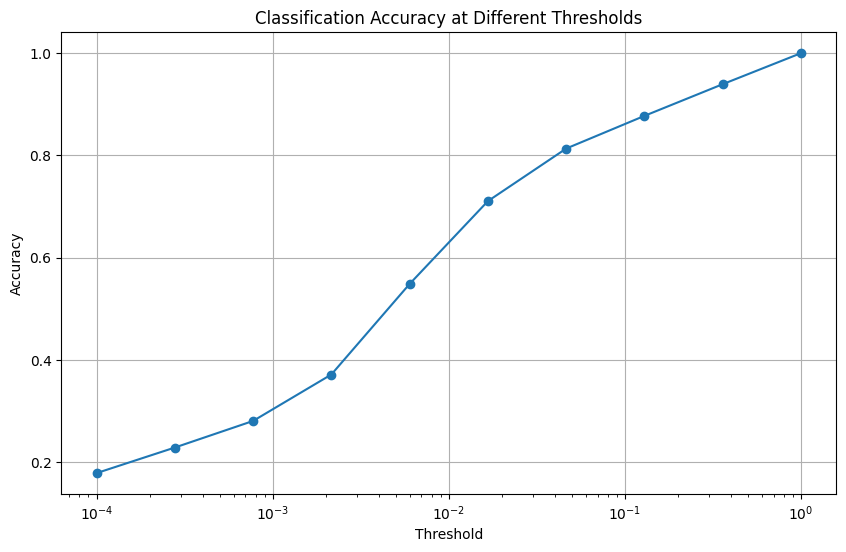

In [62]:
import gc

# Create a list of keys first
keys = list(solver_dict.keys())

for config in keys:
    print(config)
    solver = solver_dict[config]
    solver.test(test_loader)
    solver.plot_classification_accuracy()

    # Now you can safely remove the key from the dictionary
    solver_dict.pop(config)

    # Free up memory if necessary
    del solver
    torch.cuda.empty_cache()
    gc.collect()

In [133]:
'''# create data loaders
weight = 0.98
epochs = 5

model = LinearModel(panoramic=False)

optimizer = optim.Adam(model.parameters())
loss_function = WeightedBCELoss(weight_for_normal=(1-weight), weight_for_abnormal=weight)

solver = Solver(model, optimizer, loss_function, train_loader, val_loader, device, verbose=True)
interrupt = solver.train(epochs)
'''

'# create data loaders\nweight = 0.98\nepochs = 5\n\nmodel = LinearModel(panoramic=False)\n\noptimizer = optim.Adam(model.parameters())\nloss_function = WeightedBCELoss(weight_for_normal=(1-weight), weight_for_abnormal=weight)\n\nsolver = Solver(model, optimizer, loss_function, train_loader, val_loader, device, verbose=True)\ninterrupt = solver.train(epochs)\n'

In [85]:
for config, solver in xval_results.item():
    print(binary_classification_accuracy(), config)

NameError: ignored

In [86]:
xval_results

NameError: ignored

In [137]:
#solver.visualize_masks(num_images=50)

In [ ]:
'''import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import gc
del ...
gc.collect()

import torch
torch.cuda.empty_cache()'''

'import os\nos.environ[\'CUDA_LAUNCH_BLOCKING\'] = "1"\n\nimport gc\ndel ...\ngc.collect()\n\nimport torch\ntorch.cuda.empty_cache()'

In [73]:
### Setup hyperparams

weights_for_abnormal = [0.987] #np.linspace(0.98, 0.99, num=6)
lrs = [0.001]
upsamplings = ["MultiLayer"]
models = ["UNET", "LinearModel"]
out_channels_list = [[32, 64, 1]]

# Creating hyperparameter configurations with appropriate model-upsampling pairings
hyperparam_configs = [(lr, weight, model, out_channels, upsampling)
                      for weight in weights_for_abnormal
                      for lr in lrs
                      for model in models
                      for out_channels in (out_channels_list if model == "UNET" else [None])
                      for upsampling in (upsamplings if model == "UNET" else [None])]

hyperparam_configs

[(0.001, 0.987, 'UNET', [32, 64, 1], 'MultiLayer'),
 (0.001, 0.987, 'LinearModel', None, None)]

In [67]:
print(len(hyperparam_configs))

4


lr=0.001, abn_weight=0.987, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


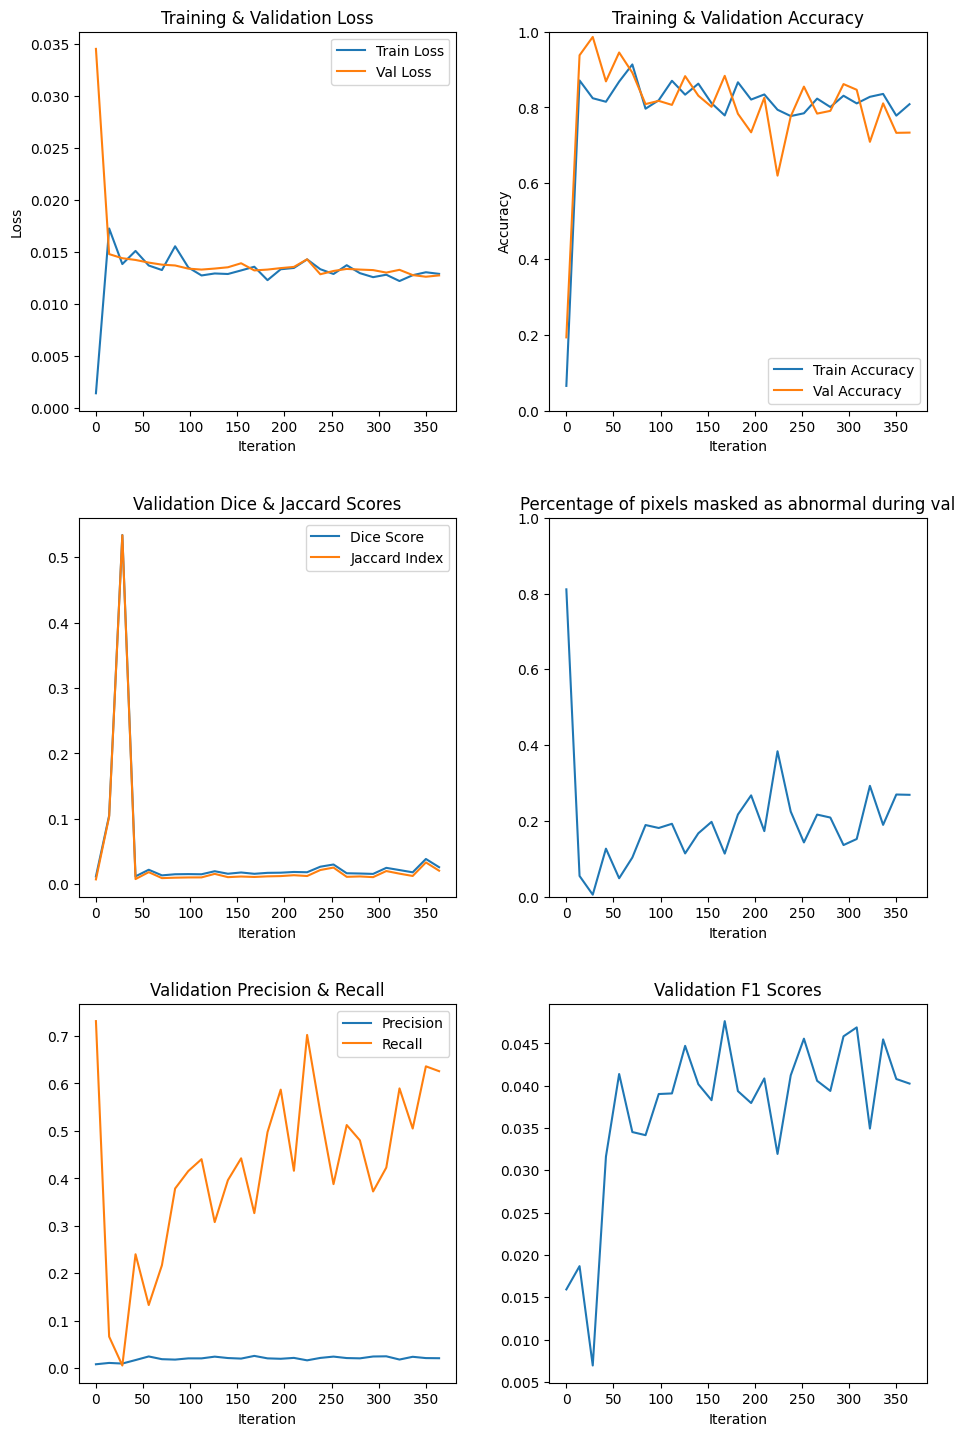


Test Metrics:
Loss: 0.013305958360433578
Accuracy: 0.8660767674446106
Dice Score: 0.110442154109478
Jaccard Index: 0.10581965744495392
Precision: 0.027288394126165613
Recall: 0.41254217509322916
F1: 0.05119068230109389
Percentage of pixels masked as abnormal: 0.13239145309778552
Binary classification accuracy: 0.5304802060127258

---------------------------------------------------------
lr=0.001, abn_weight=0.987, model=LinearModel, out_channels=None, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


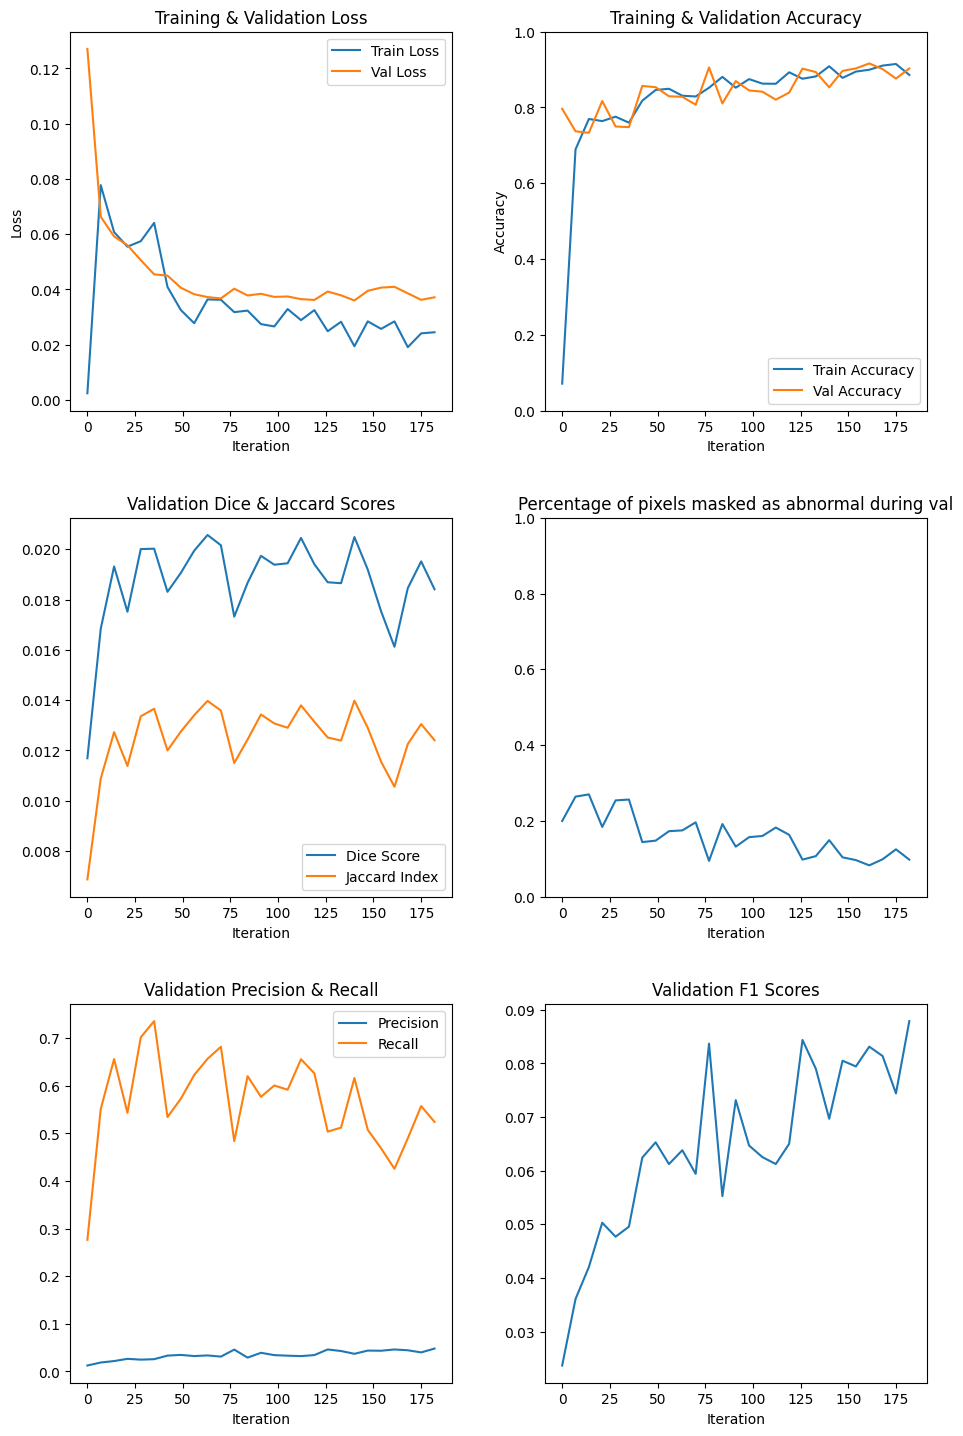


Test Metrics:
Loss: 0.039197392761707306
Accuracy: 0.9103197455406189
Dice Score: 0.01789427176117897
Jaccard Index: 0.011681548319756985
Precision: 0.04638636051500313
Recall: 0.4724733902795244
F1: 0.08447878634521731
Percentage of pixels masked as abnormal: 0.08919831057578542
Binary classification accuracy: 0.7044040560722351

---------------------------------------------------------


In [74]:
"""
Training a Linear Segmentation Head on top of the ViT.
"""
epochs = 5
verbose = False

xval_results = {}

for lr, weight, model_name, out_channels, upsampling in hyperparam_configs:
    config = f'lr={lr}, abn_weight={weight}, model={model_name}, out_channels={out_channels}, upsampling_net={upsampling}'
    print(config)

    # create data loaders
    batch_size = 256 if model_name == "UNET" else 512
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    upsample_net = OneLayerUpsamplingNet() if upsampling == "OneLayer" else DeepUpsamplingNet()
    model = UNET(upsample_net, out_channels) if model_name == "UNET" else LinearModel()

    optimizer = optim.Adam(model.parameters(), lr)
    loss_function = WeightedBCELoss(weight_for_normal=(1-weight), weight_for_abnormal=weight)

    solver = Solver(model, optimizer, loss_function, train_loader, val_loader, device, verbose)

    interrupt = solver.train(epochs)
    if interrupt:
        break

    solver.test(test_loader)
    print("\n---------------------------------------------------------")

    # record cross validation results for hyperparameter configuration
    xval_results[config] = solver

    torch.save(solver.model.state_dict(), f'saved_models/{config}_model_state.pth')


In [70]:
xval_results

{'lr=0.001, abn_weight=0.988, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer': <__main__.Solver at 0x78262f338310>,
 'lr=0.001, abn_weight=0.988, model=LinearModel, out_channels=None, upsampling_net=None': <__main__.Solver at 0x78262f24f730>,
 'lr=0.001, abn_weight=0.99, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer': <__main__.Solver at 0x78262f33afe0>,
 'lr=0.001, abn_weight=0.99, model=LinearModel, out_channels=None, upsampling_net=None': <__main__.Solver at 0x7825dc7c72e0>}

lr=0.001, abn_weight=0.988, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


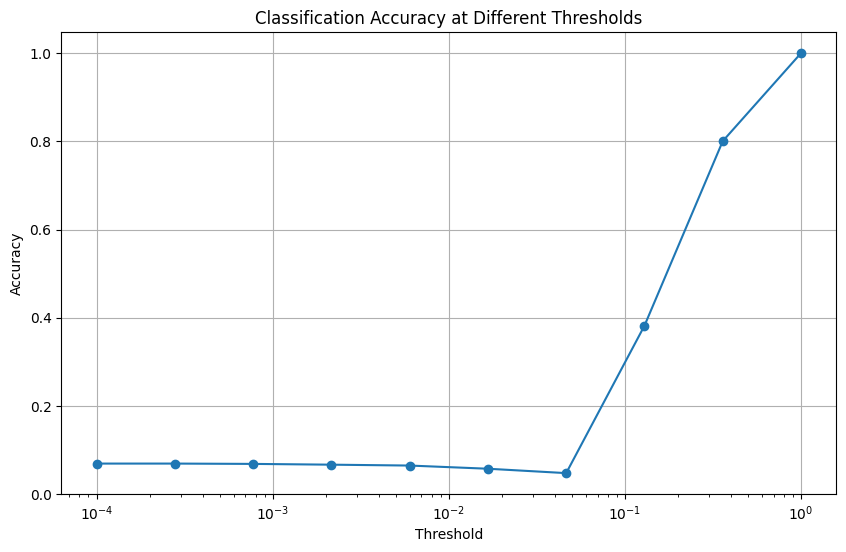

lr=0.001, abn_weight=0.988, model=LinearModel, out_channels=None, upsampling_net=None


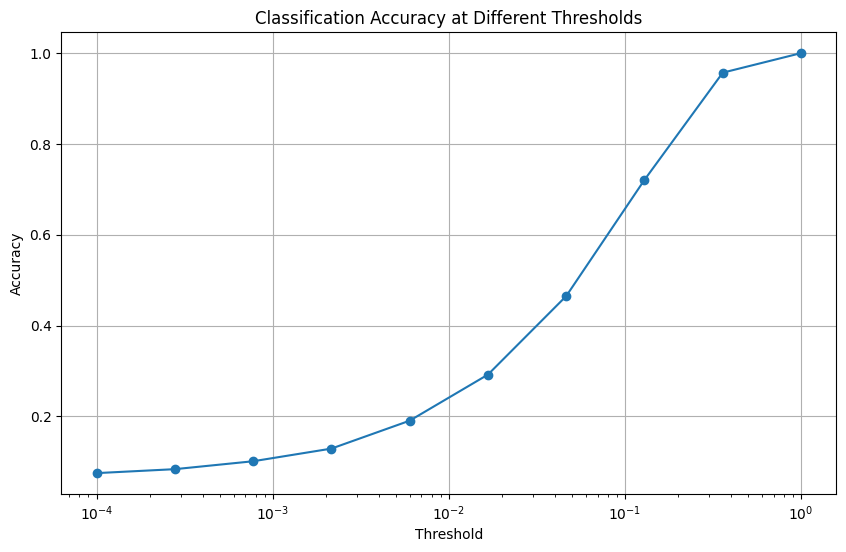

lr=0.001, abn_weight=0.99, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer


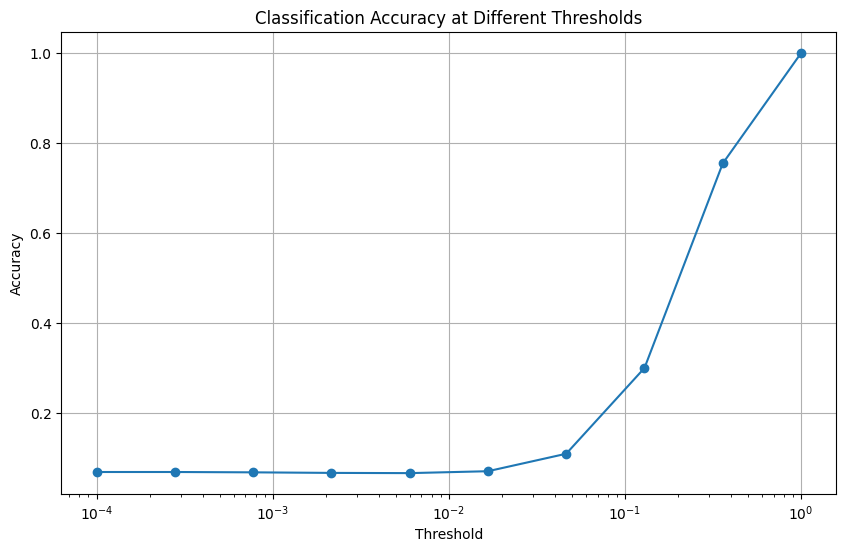

lr=0.001, abn_weight=0.99, model=LinearModel, out_channels=None, upsampling_net=None


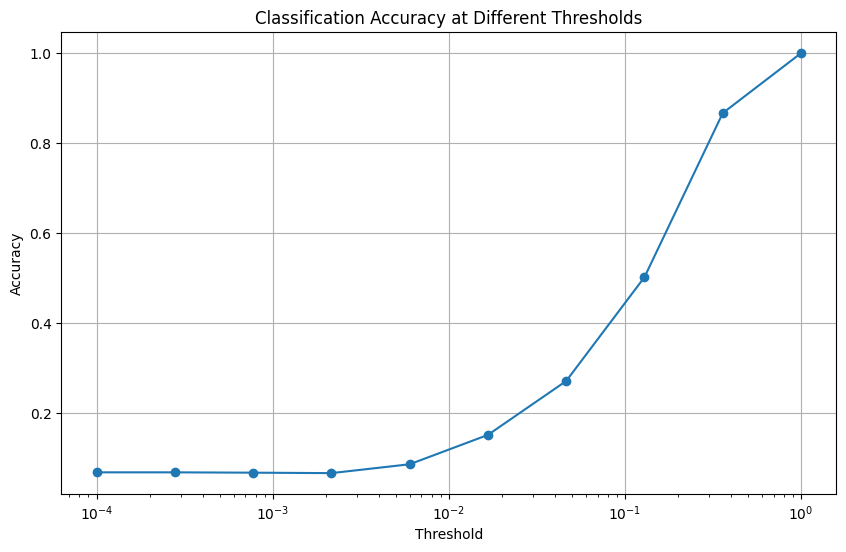

In [72]:
for config, solver in xval_results.items():
    print(config)
    # Define the thresholds
    thresholds = np.geomspace(1e-5, 1, num=10)

    # Calculate accuracy at each threshold
    solver.plot_classification_accuracy()

In [ ]:
import matplotlib.pyplot as plt

for config, solver in xval_results.items():

    # Define the thresholds
    thresholds = np.geomspace(1e-5, 1, num=10)

    # Calculate accuracy at each threshold
    accuracies = [solver.classification_accuracy(threshold) for threshold in thresholds]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, accuracies, marker='o', linestyle='-')
    plt.title('Binary Classification Accuracy at Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.xscale('log')  # Set the x-axis to a logarithmic scale
    plt.grid(True)
    plt.show()

In [ ]:
for config, solver in xval_results.items():
    acc_plus_recall = [solver.val_accs[idx] + solver.val_recall[idx] for idx in range(len(solver.xs))]
    print(config, max(acc_plus_recall))


lr=0.001, abn_weight=0.985, model=UNET, out_channels=[32, 64, 1], upsampling_net=MultiLayer 1.383475333067555
lr=0.001, abn_weight=0.985, model=UNET, out_channels=[32, 64, 1], upsampling_net=OneLayer 1.3464373879875011
lr=0.001, abn_weight=0.985, model=UNET, out_channels=[32, 64, 3], upsampling_net=MultiLayer 1.3666838061417308
lr=0.001, abn_weight=0.985, model=UNET, out_channels=[32, 64, 3], upsampling_net=OneLayer 1.374844530619053
lr=0.001, abn_weight=0.985, model=LinearModel, out_channels=None, upsampling_net=None 1.4923252527948287


----------------------------
lr=0.001, abn_weight=0.99, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


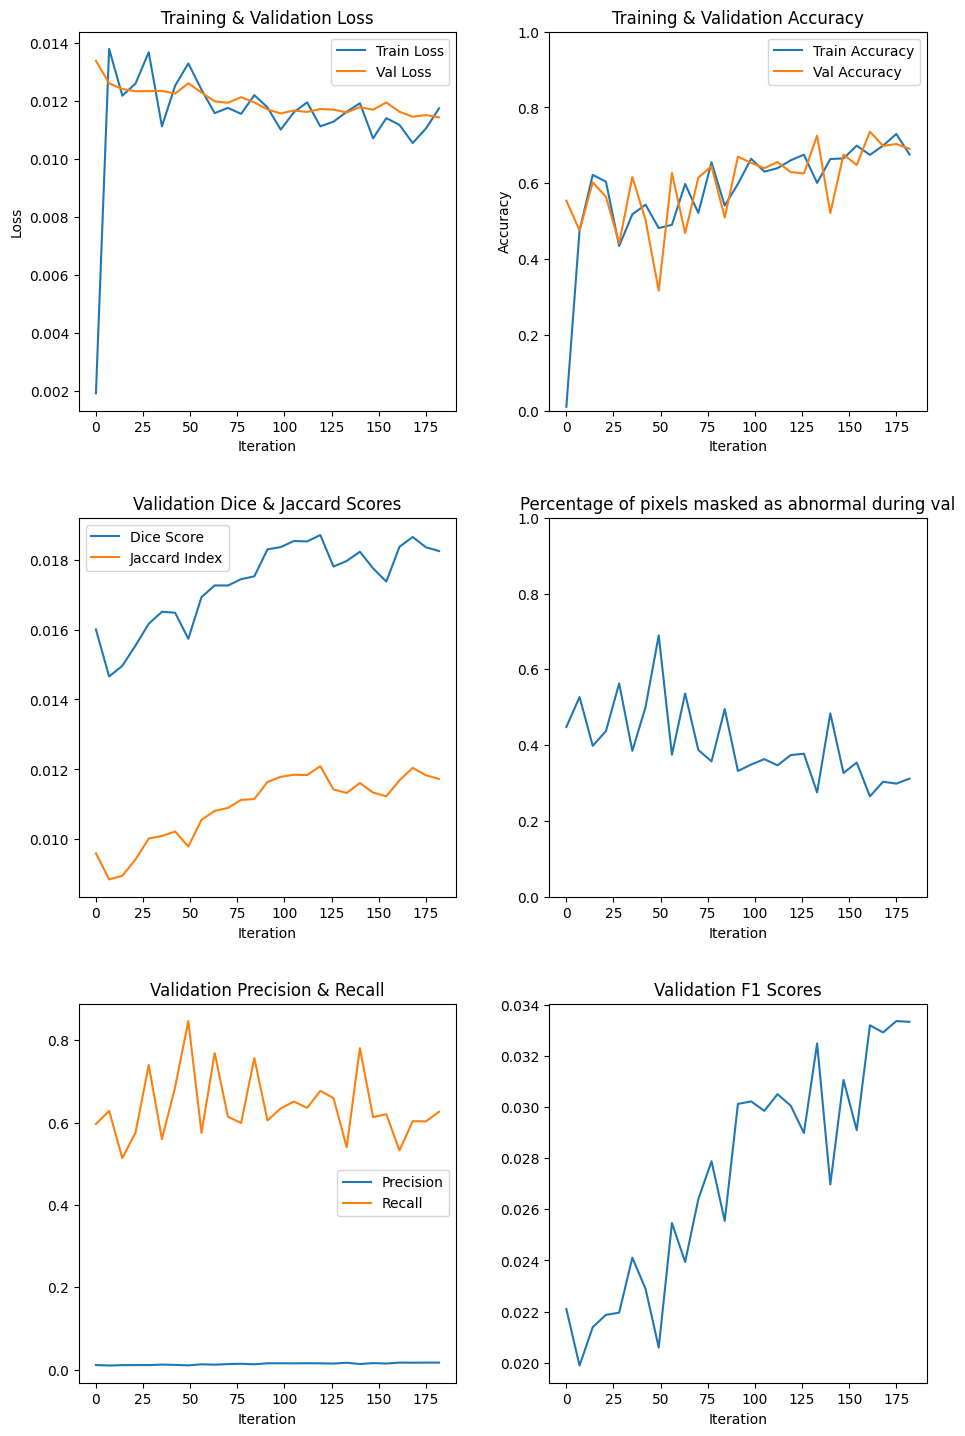

----------------------------
lr=0.001, abn_weight=0.99, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


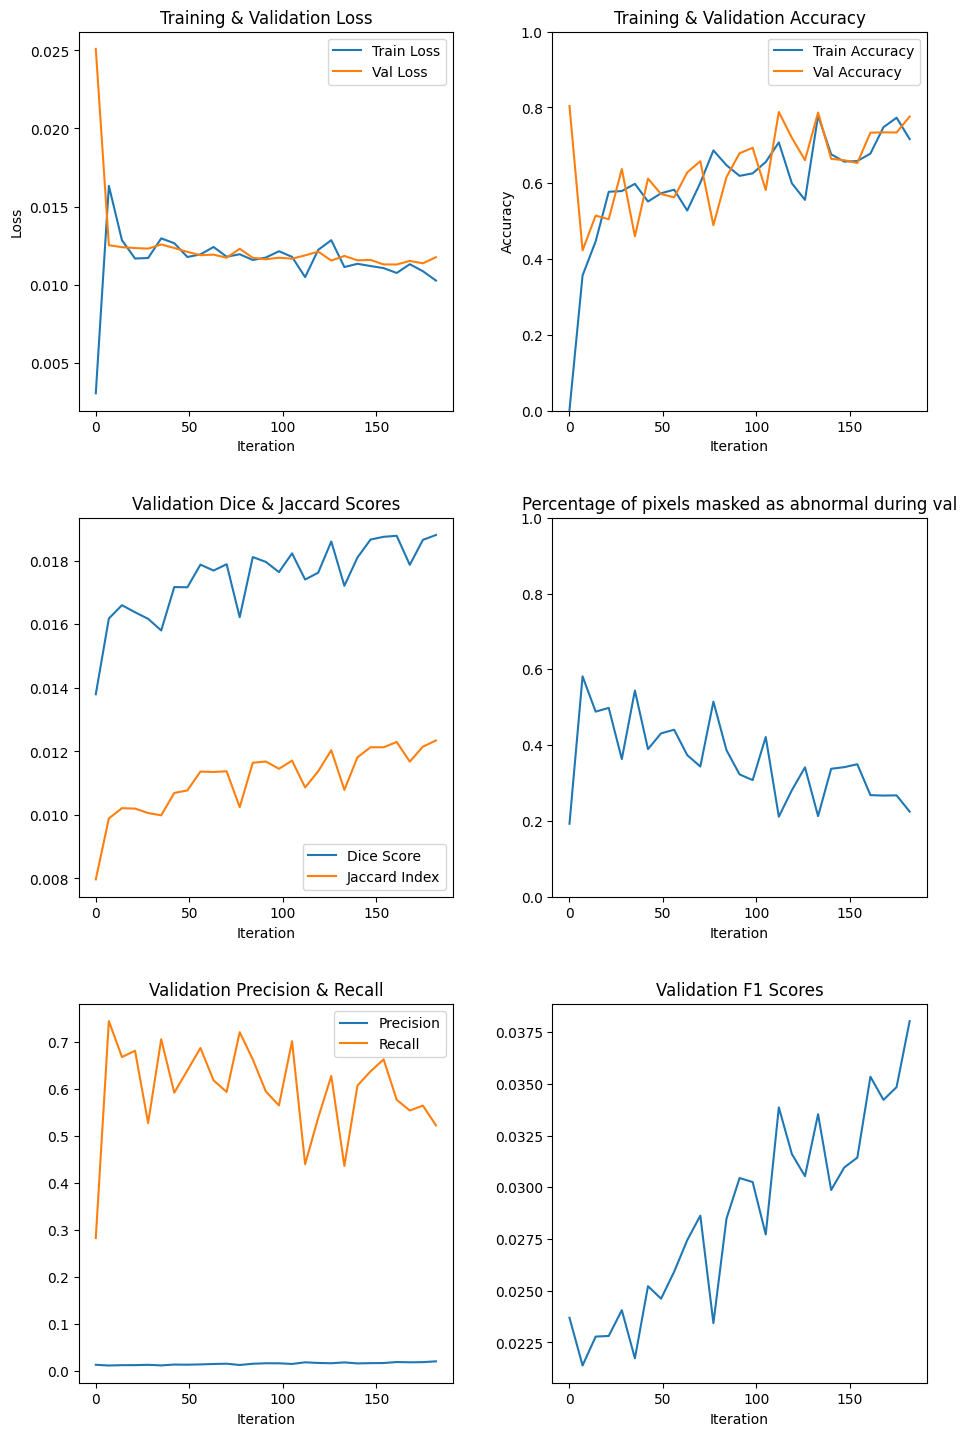

----------------------------
lr=0.001, abn_weight=0.99, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


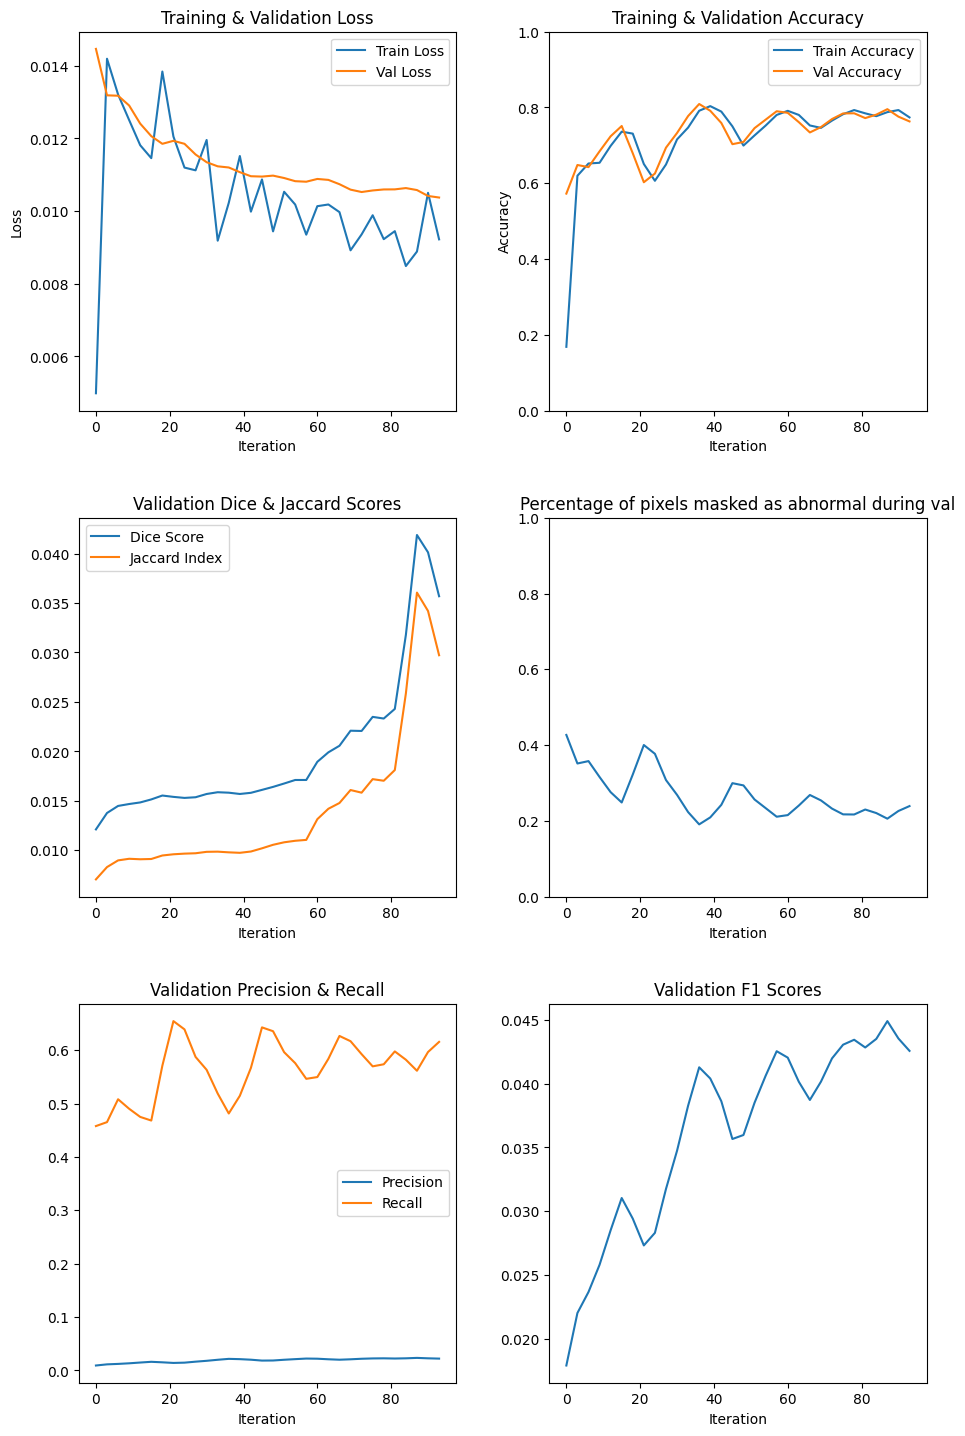

----------------------------
lr=0.01, abn_weight=0.99, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


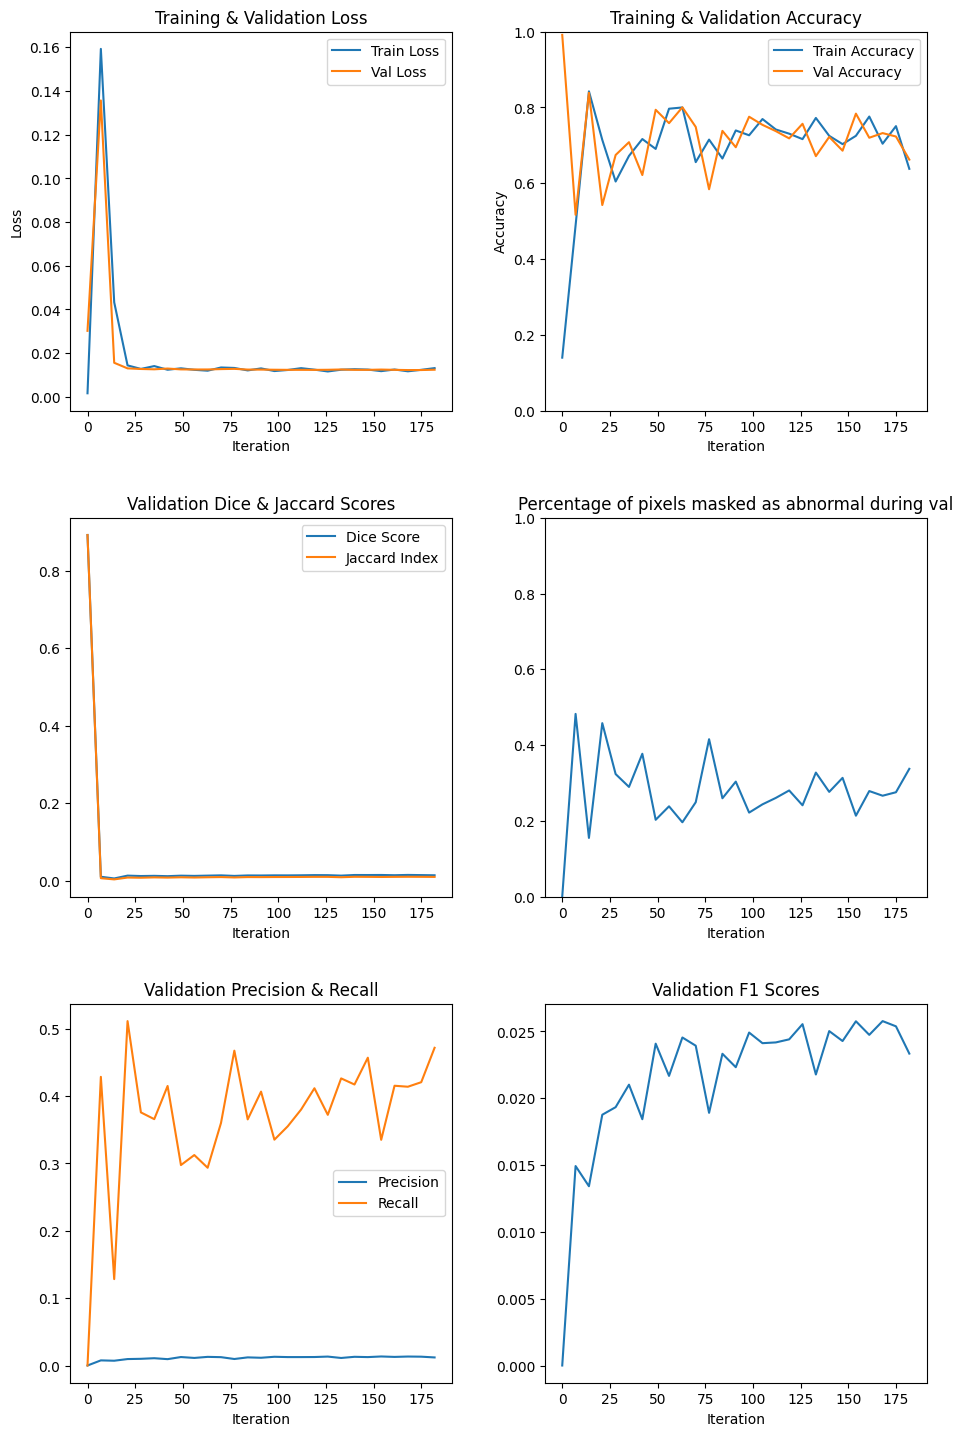

----------------------------
lr=0.01, abn_weight=0.99, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


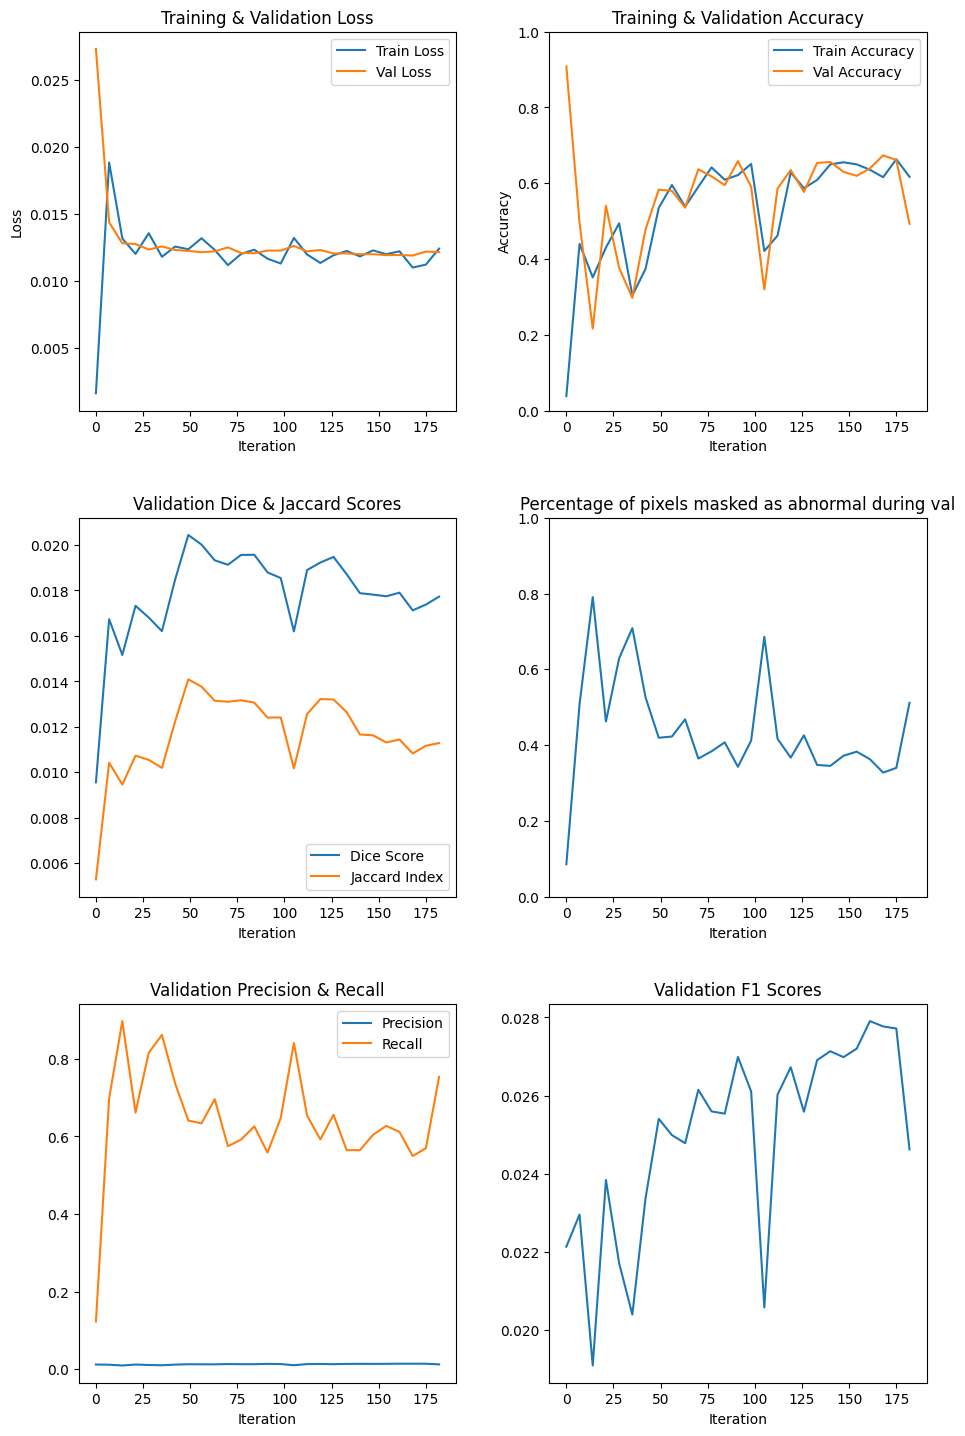

----------------------------
lr=0.01, abn_weight=0.99, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


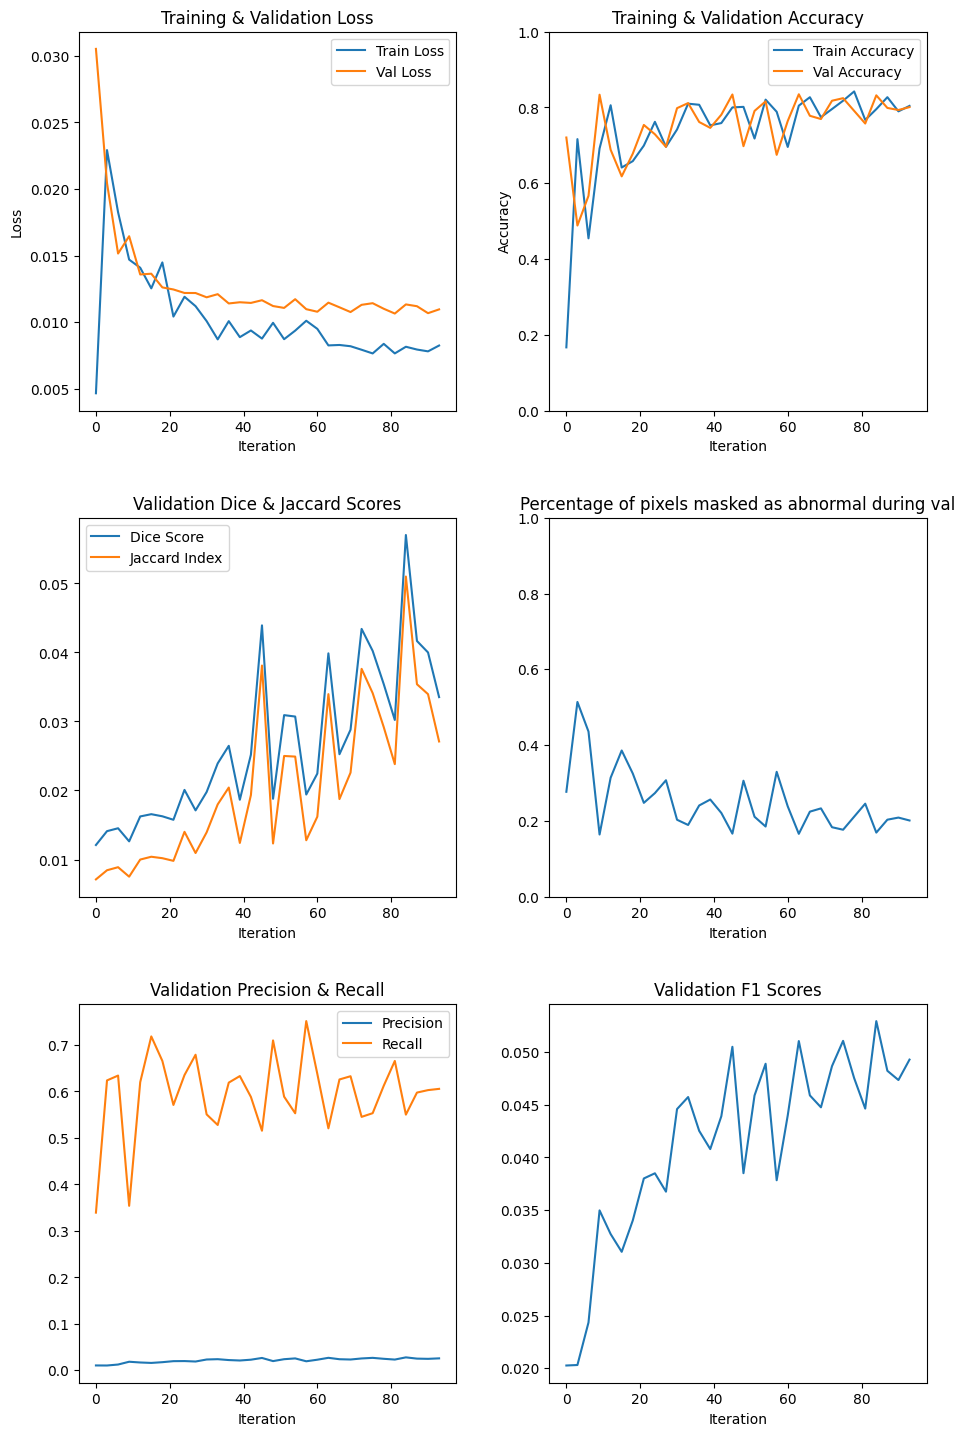

----------------------------
lr=0.001, abn_weight=0.98, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


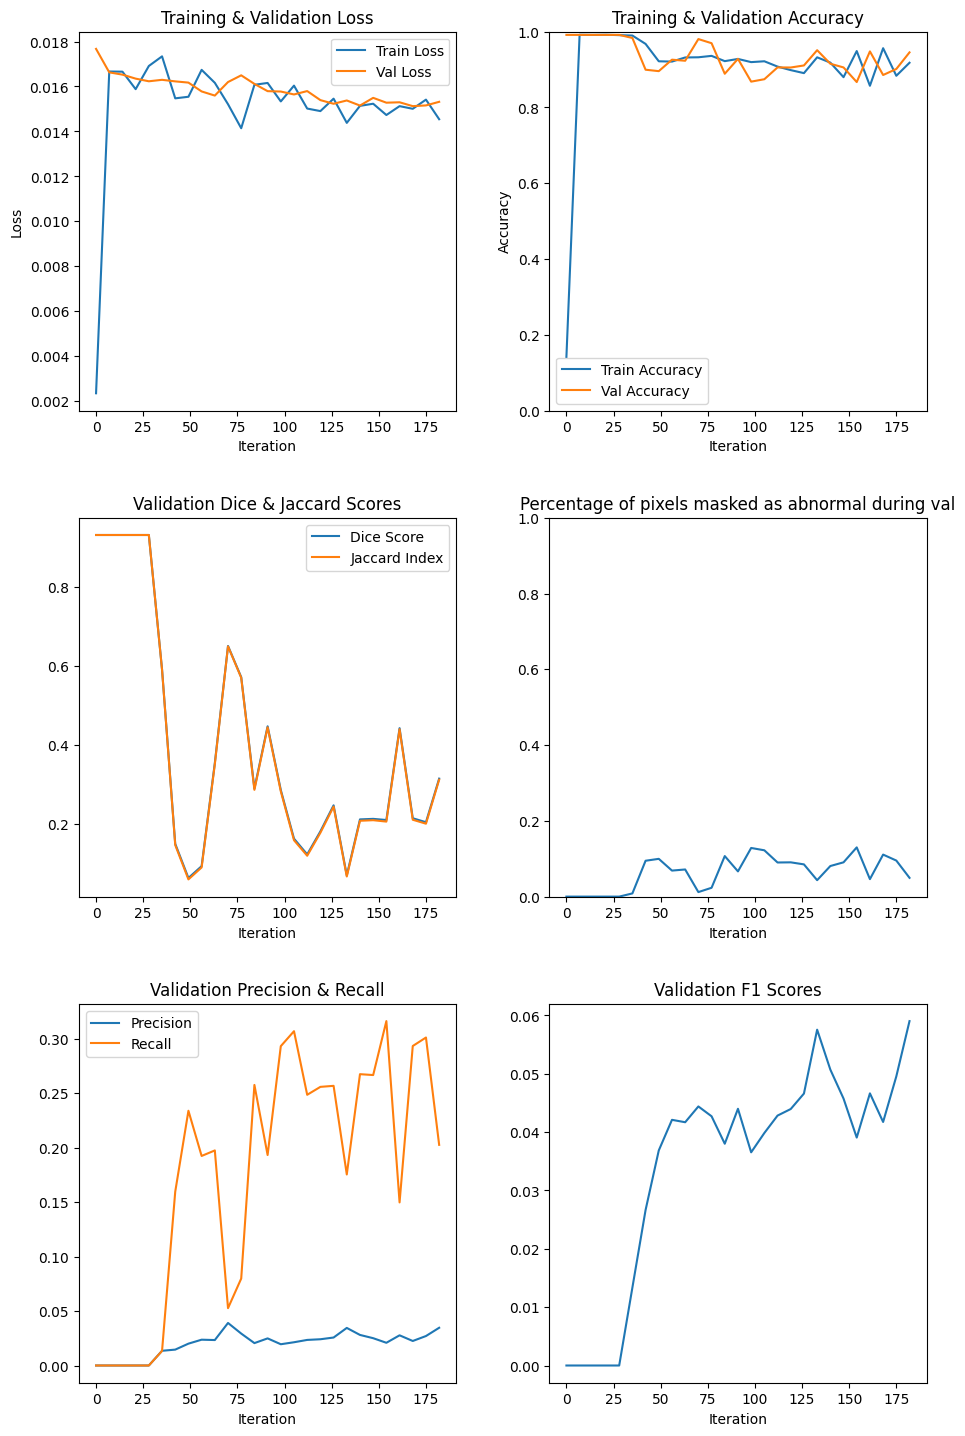

----------------------------
lr=0.001, abn_weight=0.98, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


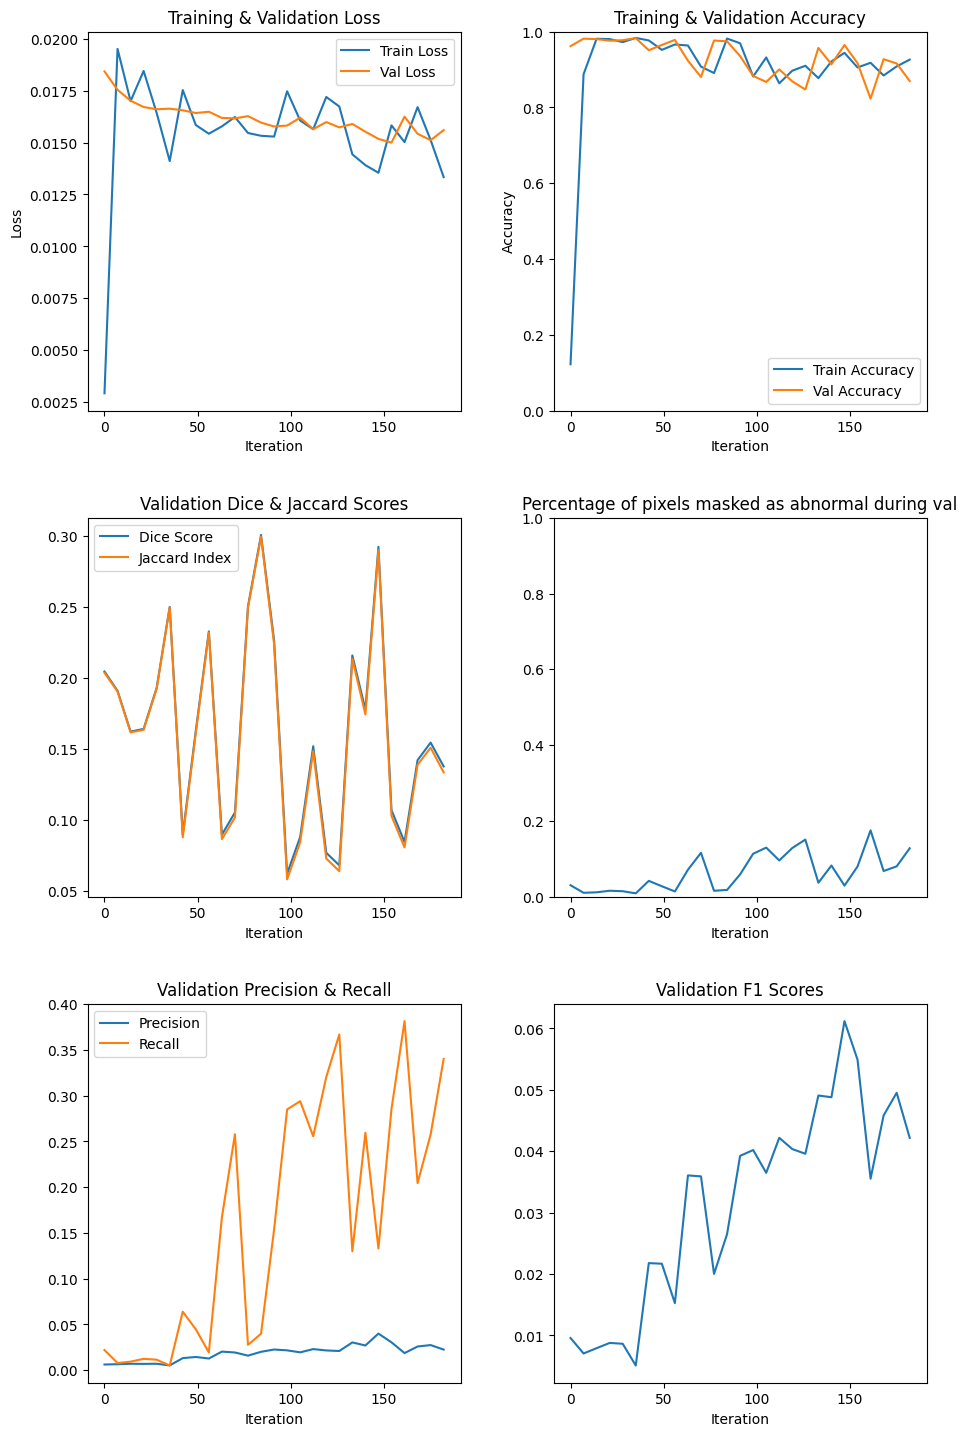

----------------------------
lr=0.001, abn_weight=0.98, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


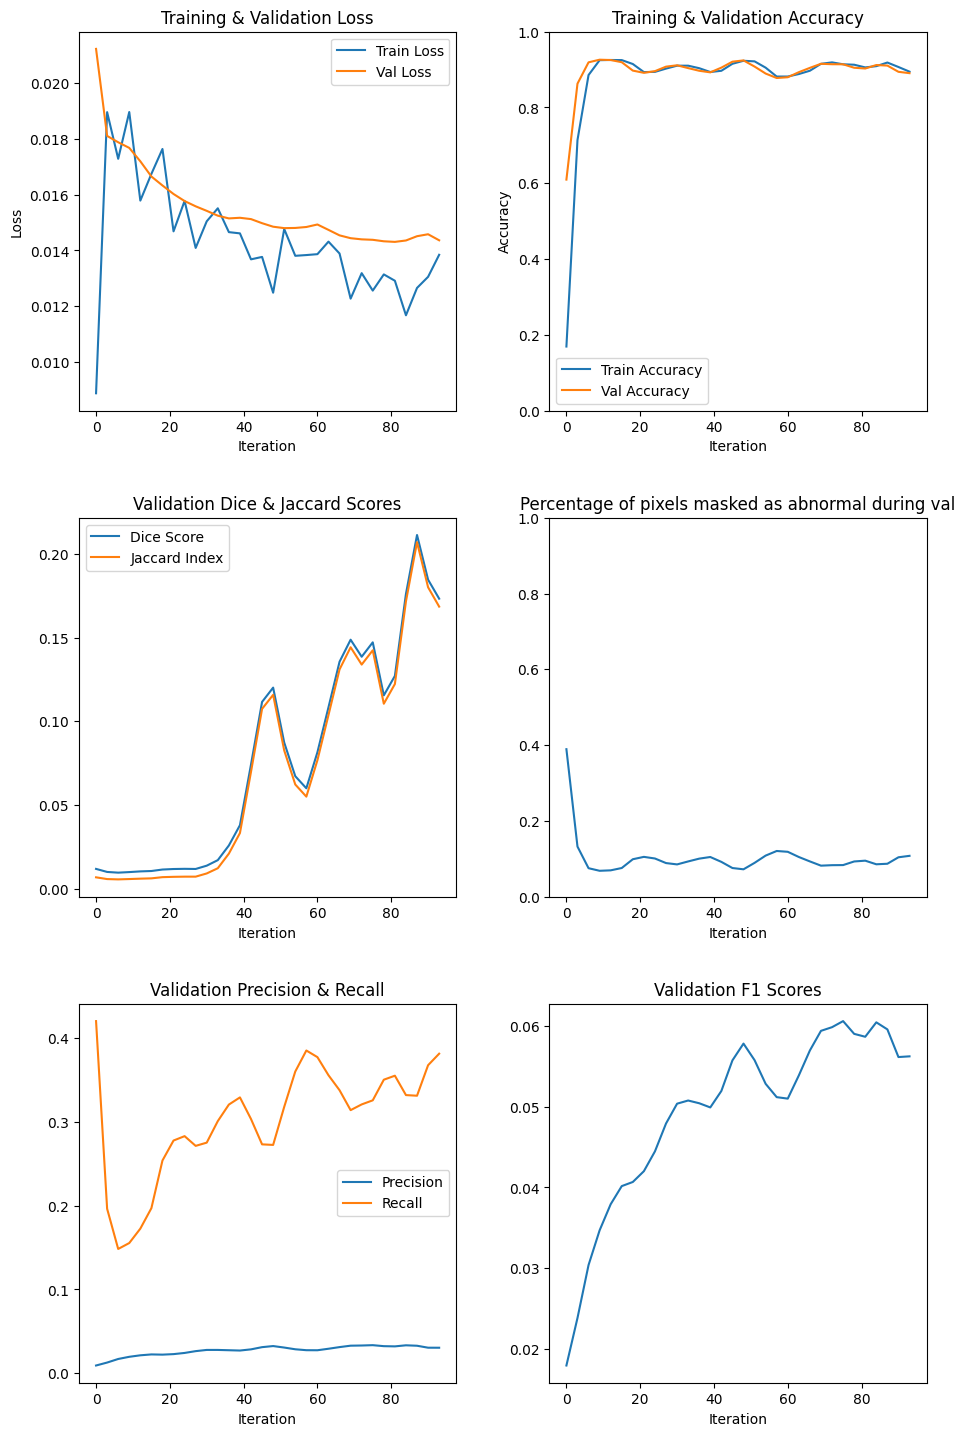

----------------------------
lr=0.01, abn_weight=0.98, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


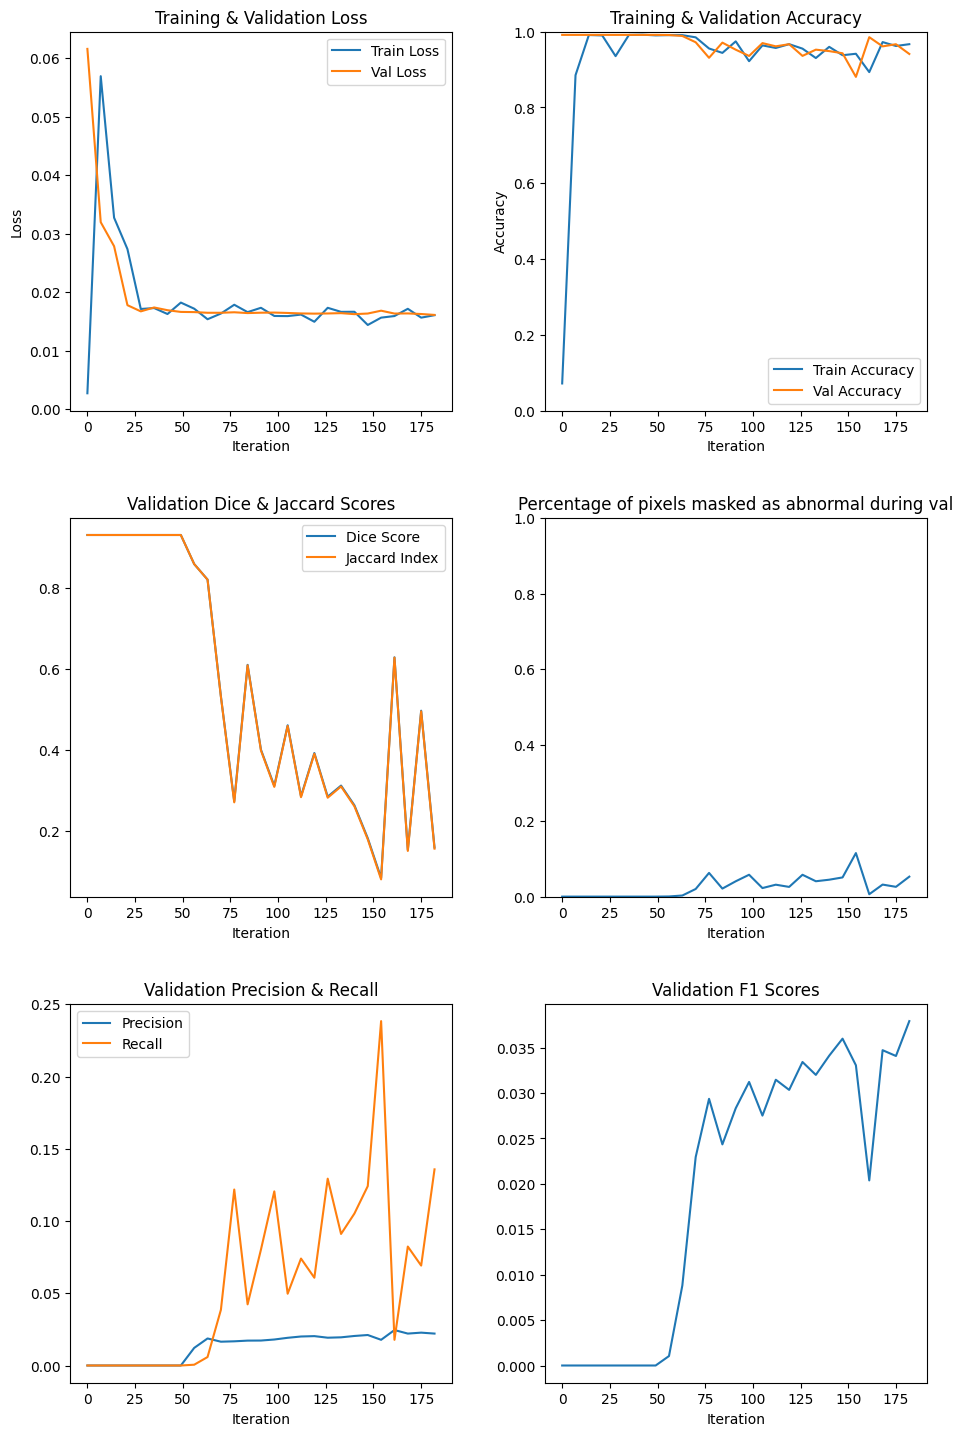

----------------------------
lr=0.01, abn_weight=0.98, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


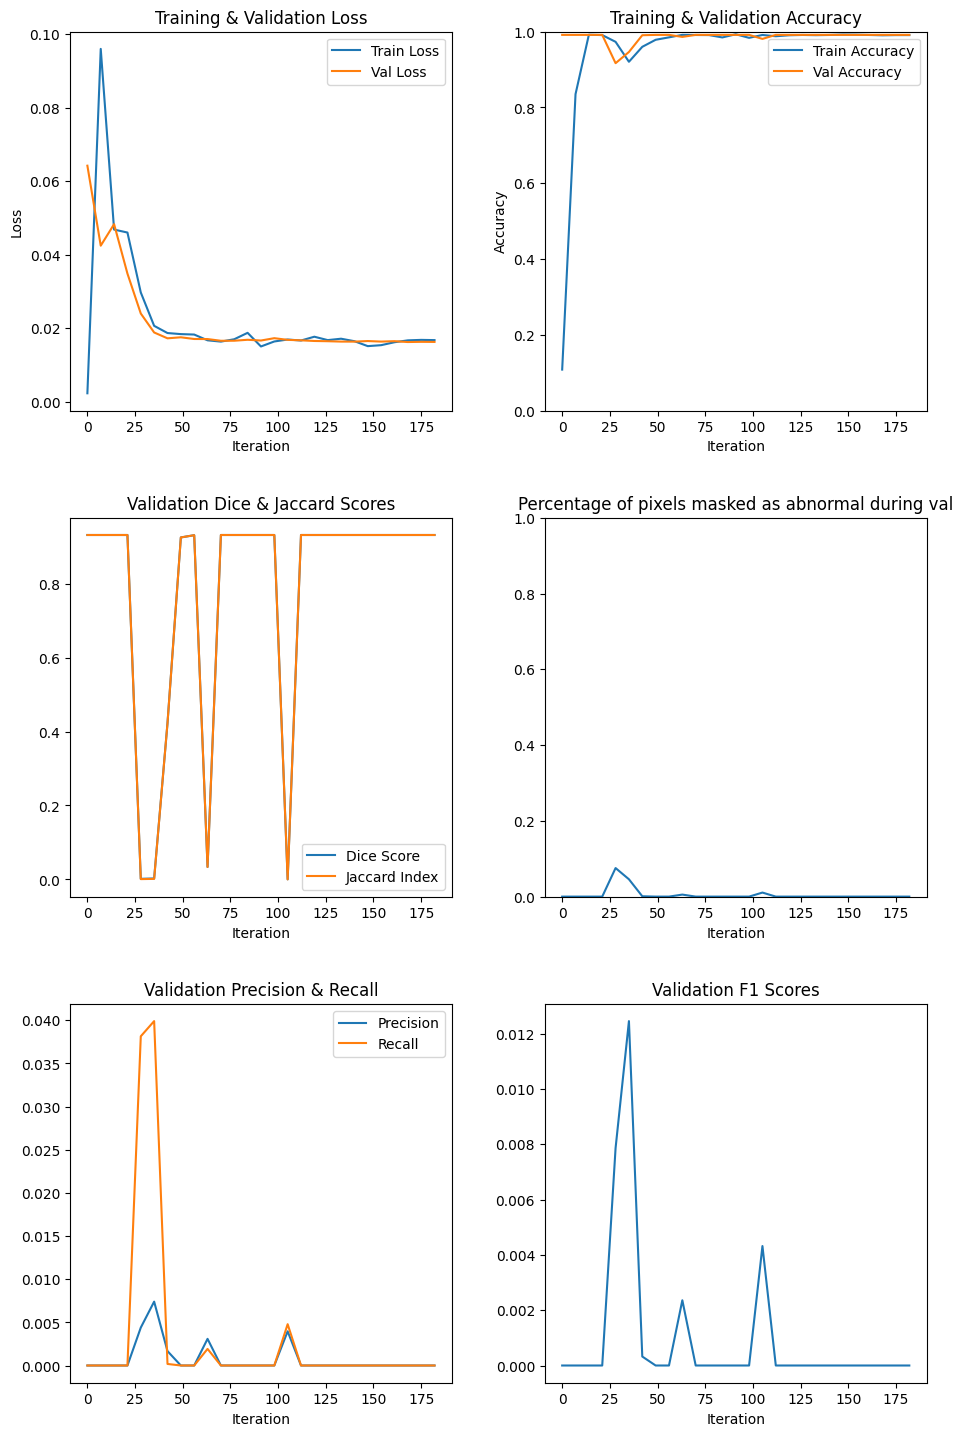

----------------------------
lr=0.01, abn_weight=0.98, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


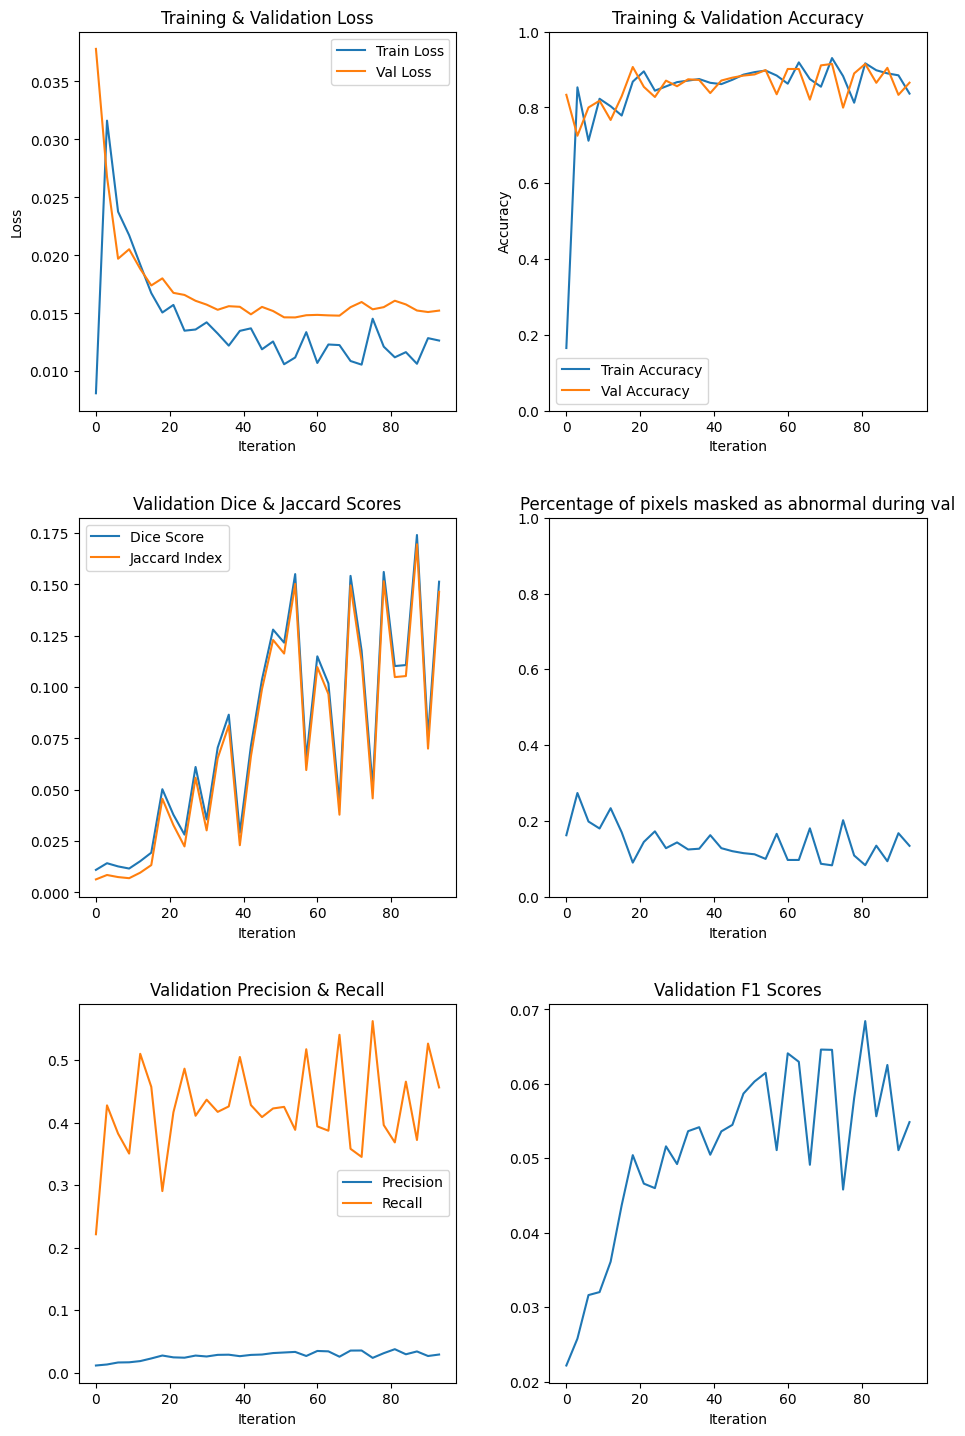

----------------------------
lr=0.001, abn_weight=0.97, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


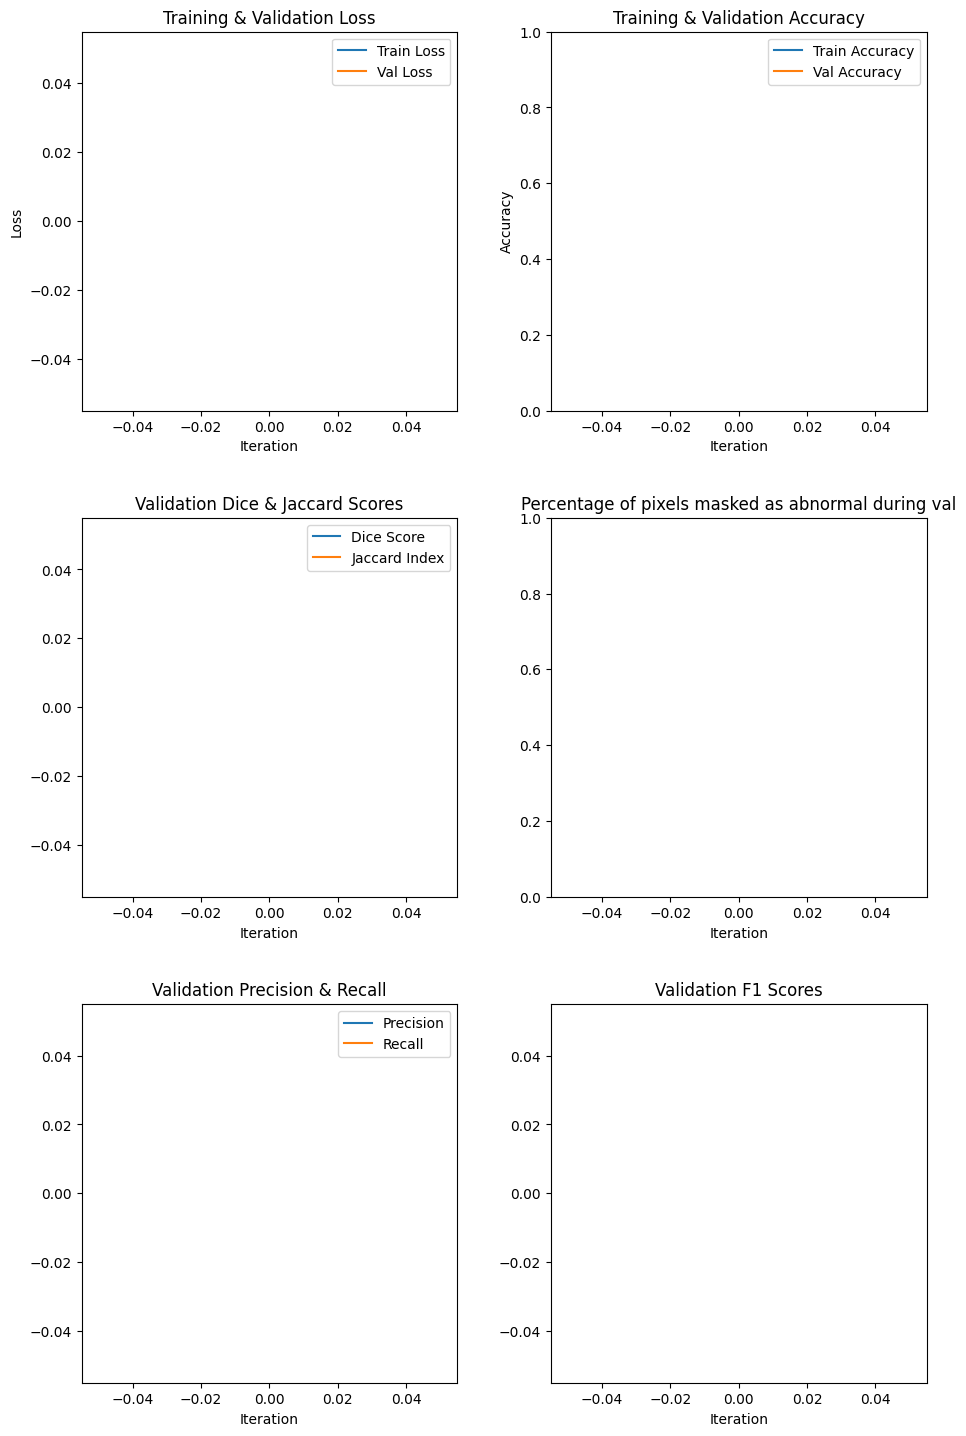

----------------------------
lr=0.001, abn_weight=0.97, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


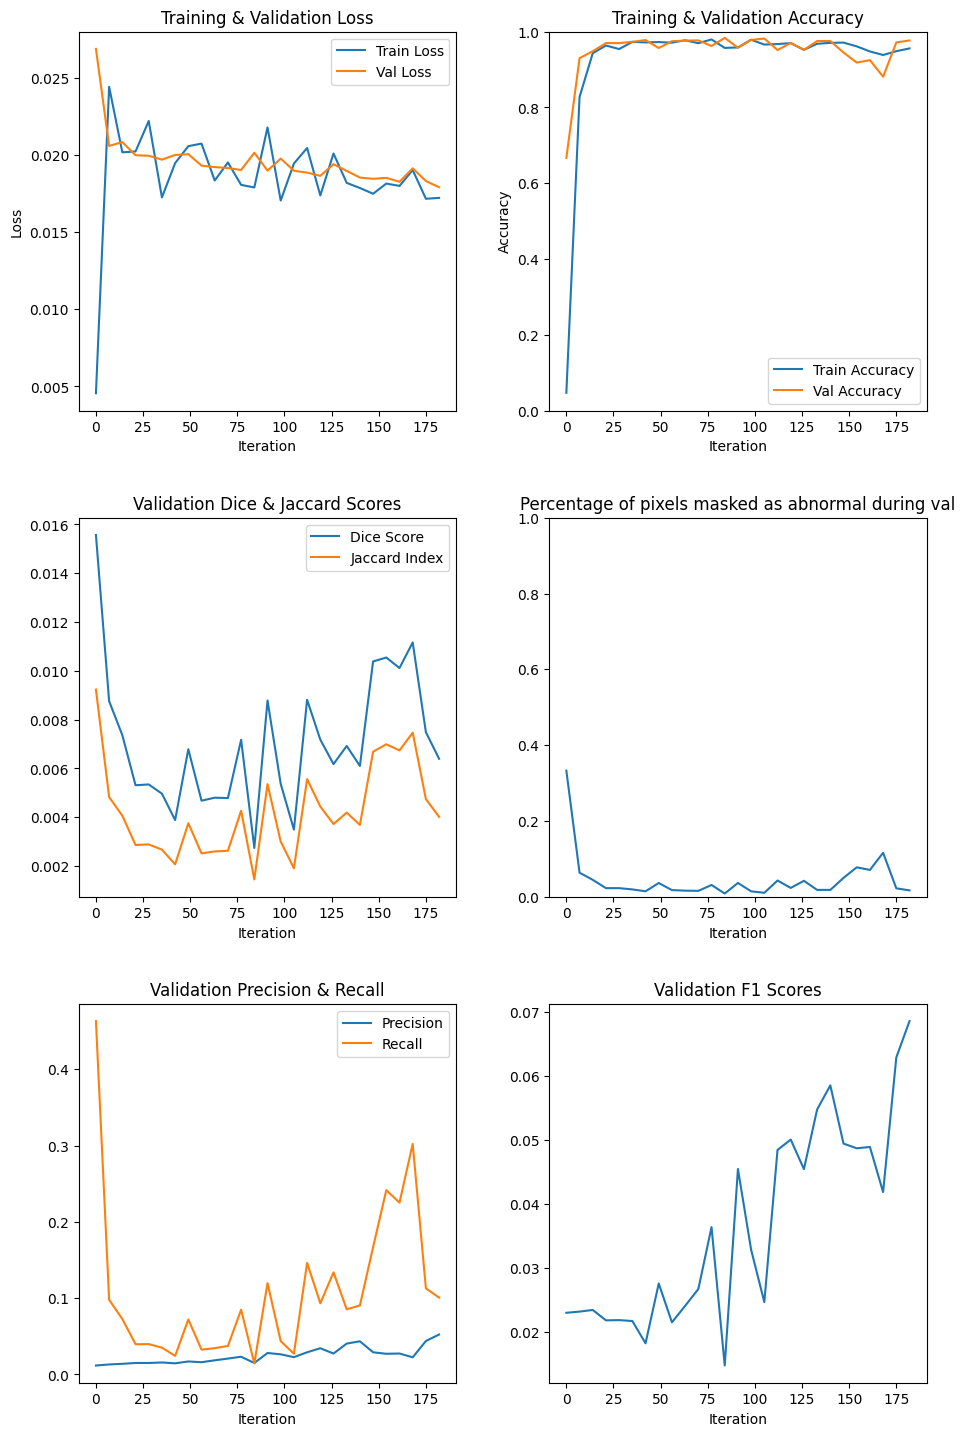

----------------------------
lr=0.001, abn_weight=0.97, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


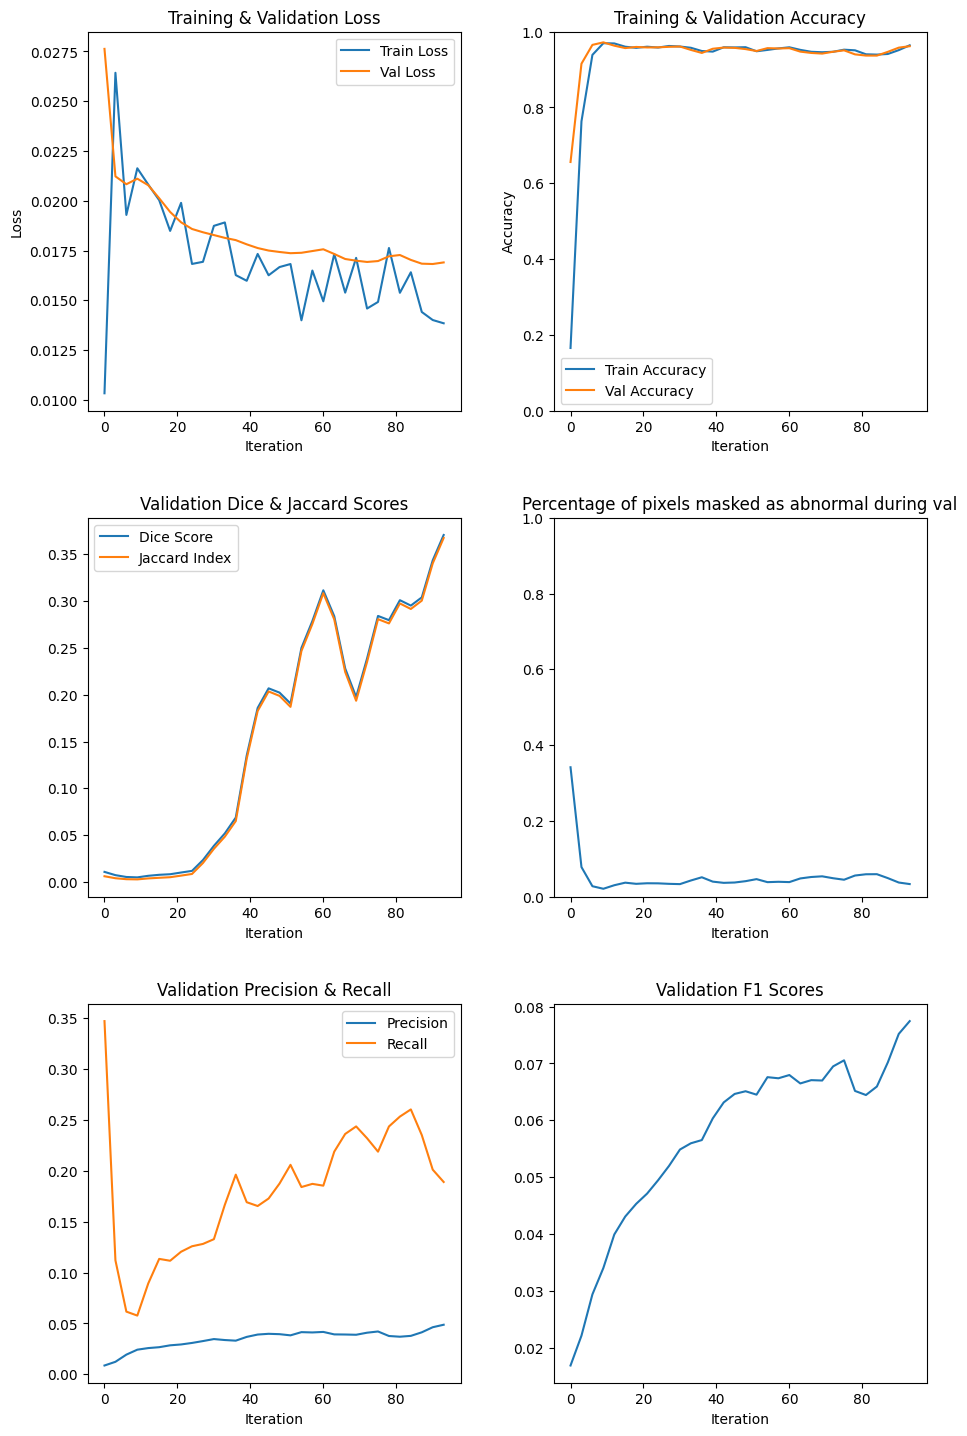

----------------------------
lr=0.01, abn_weight=0.97, model=UNET, upsampling_net=MultiLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


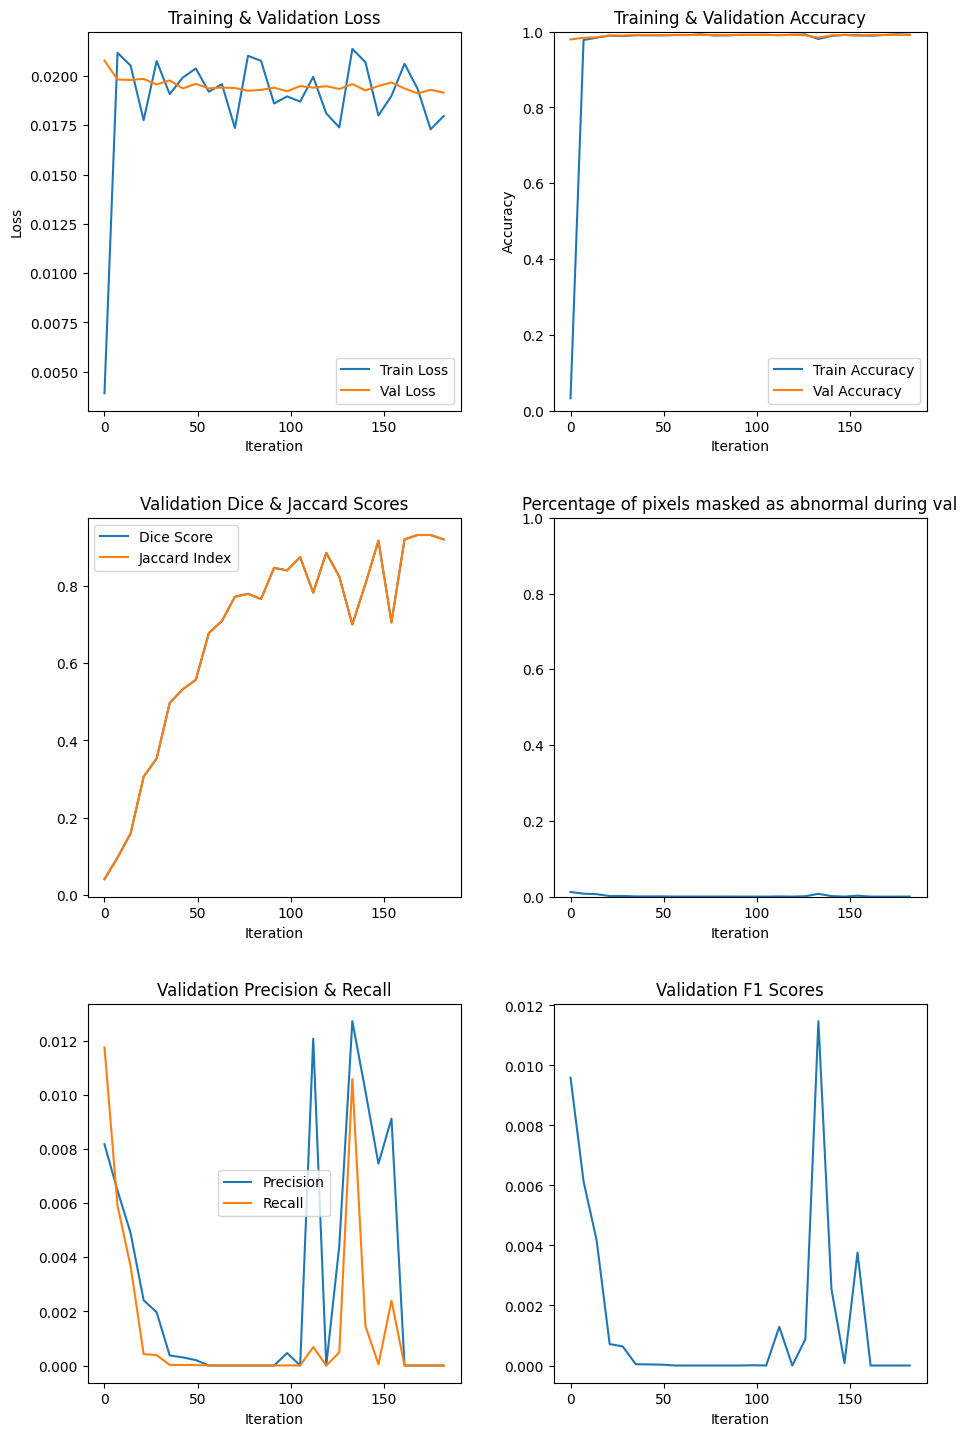

----------------------------
lr=0.01, abn_weight=0.97, model=UNET, upsampling_net=OneLayer


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


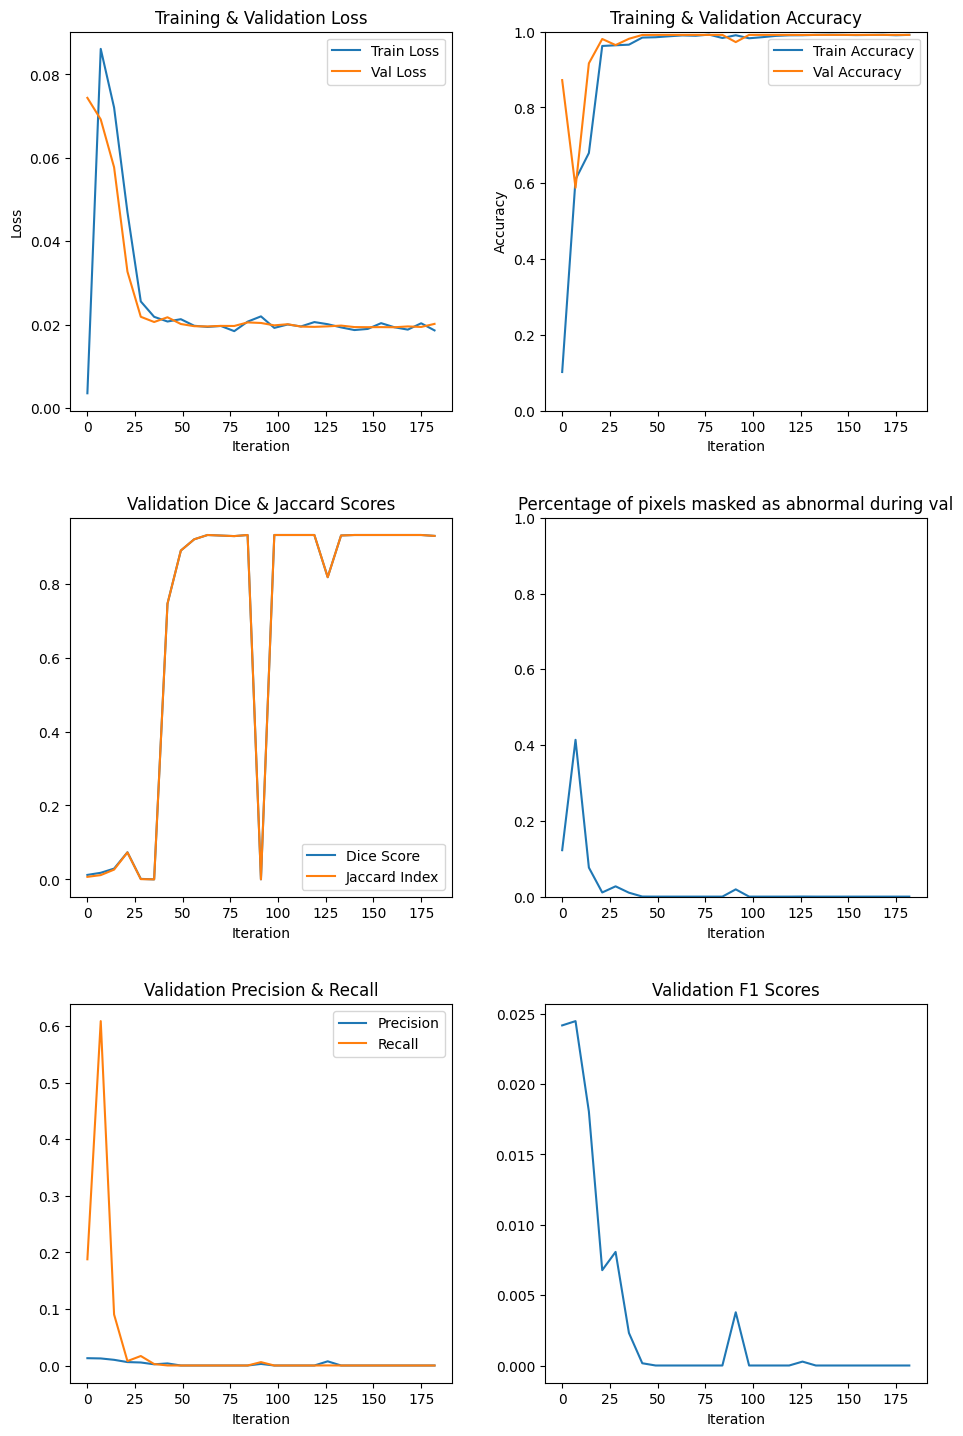

----------------------------
lr=0.01, abn_weight=0.97, model=LinearModel, upsampling_net=None


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


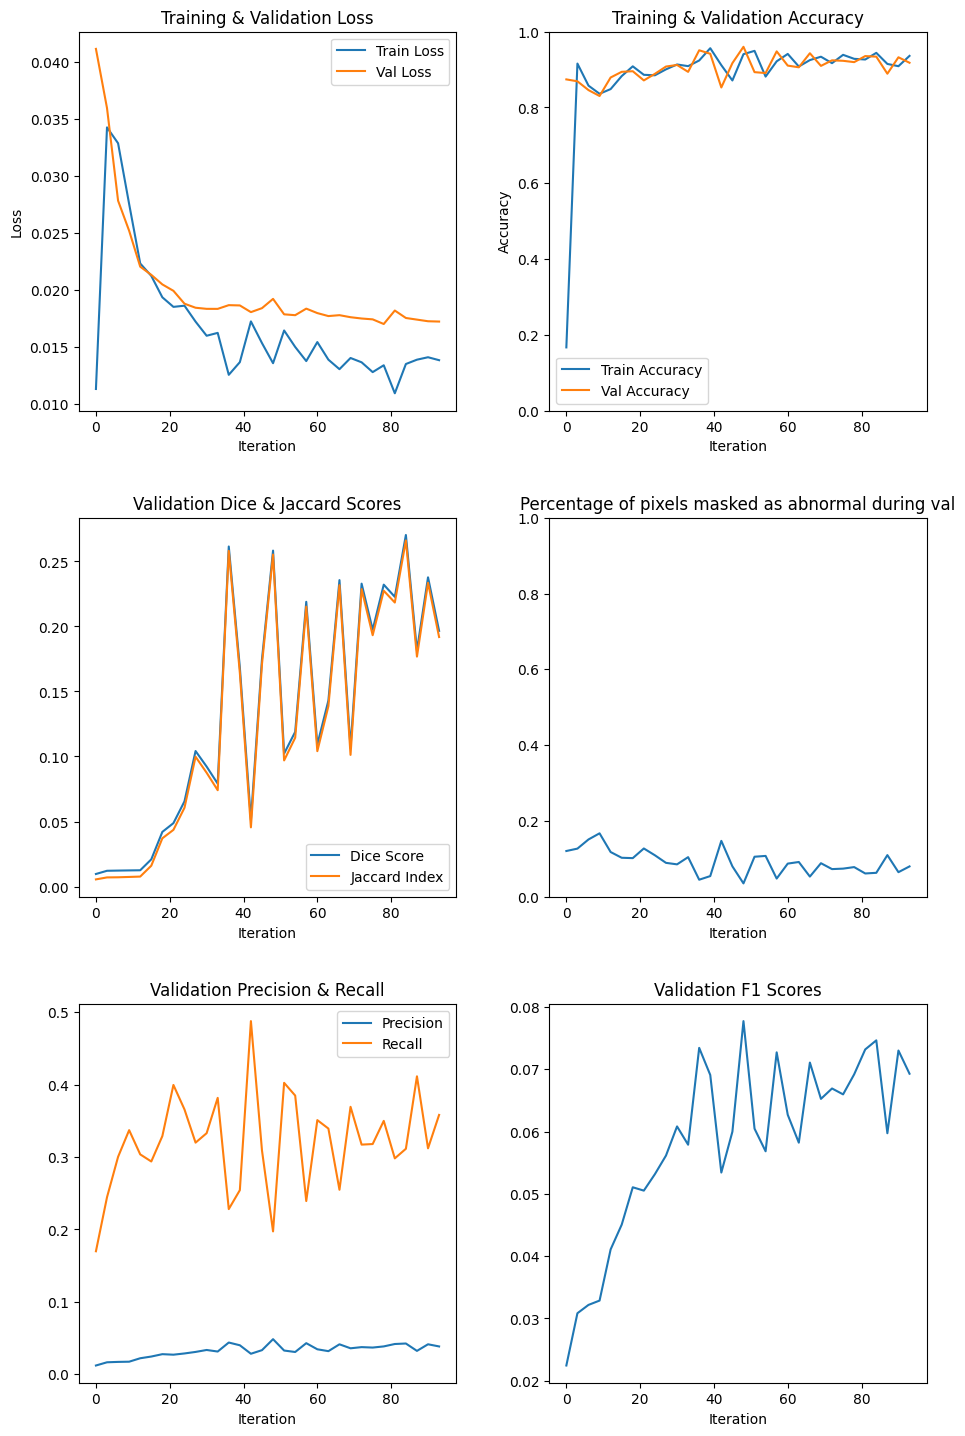

In [ ]:
"""
Training a Linear Segmentation Head on top of the ViT.
Notes:
 - using the weighted BCE loss metric appears to perform better than focal loss or is at least easier to tune.
 - must finetune weight 'weight_for_normal' and 'weight_for_abnormal' hyperparameters. Should they sum to one?
 - must test how batch size effects performance
 - should try a few more epochs to finalize convergence

epochs = 5
verbose=False

xval_results = {}

for lr, weight, model_name, out_channels, upsampling in hyperparam_configs:
    print(f'----------------------------')
    print(f'lr={lr}, abn_weight={weight}, model={model_name}, out_channels={out_channels}, upsampling_net={upsampling}')

    # create data loaders
    batch_size = 512 if model_name == "UNET" else 1024
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    upsample_net = OneLayerUpsamplingNet() if upsampling == "OneLayer" else DeepUpsamplingNet()
    model = UNET(upsample_net, out_channels) if model_name == "UNET" else LinearModel()

    optimizer = optim.Adam(model.parameters(), lr)
    loss_function = WeightedBCELoss(weight_for_normal=(1-weight), weight_for_abnormal=weight)

    solver = Solver(model, optimizer, loss_function, train_loader, val_loader, device, verbose=verbose)
    interrupt = solver.train(epochs)
    solver.test(test_loader)

    # record cross validation results for hyperparameter configuration
    xval_results[f'lr={lr}, abn_weight={weight}, model={model_name}, out_channels={out_channels}, upsampling_net={upsampling}'] = solver

    if interrupt:
        break
"""

In [ ]:
# Run tests
for config, solver in xval_results.items():
      print(config)
      solver.test(test_loader)
      print("\n---------------------------------------------------------")

lr=0.001, abn_weight=0.99, model=UNET, upsampling_net=MultiLayer

Test Metrics:
Loss: 0.010705851858218056
Accuracy: 0.7199974656105042
Dice Score: 0.020865912083536386
Jaccard Index: 0.01439536502584815
Precision: 0.022877220012093417
Recall: 0.7206462872301718
F1: 0.04430848221452001
Percentage of pixels masked as abnormal: 0.28394502825108414

---------------------------------------------------------
lr=0.001, abn_weight=0.99, model=UNET, upsampling_net=OneLayer

Test Metrics:
Loss: 0.010577662648648416
Accuracy: 0.7019309103488922
Dice Score: 0.02128310687839985
Jaccard Index: 0.014840635005384684
Precision: 0.02187016820042252
Recall: 0.7360145499399713
F1: 0.0424419679036629
Percentage of pixels masked as abnormal: 0.30225236589064997

---------------------------------------------------------
lr=0.001, abn_weight=0.99, model=LinearModel, upsampling_net=None

Test Metrics:
Loss: 0.0097658928709893
Accuracy: 0.7560704946517944
Dice Score: 0.03786276187747717
Jaccard Index: 0.031827

In [ ]:
for config_name, solver in xval_results.items():
    torch.save(solver.model.state_dict(), f'saved_models/{config_name}_model_state.pth')
    # If you need to save the optimizer state as well
    # torch.save(solver.optimizer.state_dict(), f'{config_name}_optimizer_state.pth')


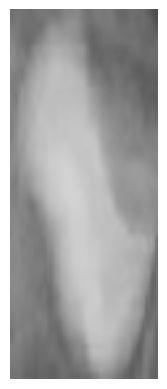

797-1.JPG


In [132]:
import matplotlib.pyplot as plt
import cv2
image_id = '797-1.JPG'
# Read the image using matplotlib.image
im = cv2.imread(f"/content/Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2/{image_id}")
# Display the image with interactive features (pan/zoom)
plt.figure()
plt.imshow(im)
plt.axis('off')  # Turn off axis labels
plt.show()
print(image_id)

In [129]:
idxs = list(sorted(os.listdir(os.path.join(root, "/content/Labeled_Cropped_Images_V2/Labeled_Cropped_Images_V2/"))))
[idx for (idx, el) in enumerate(idxs) if ("797" in el)]

[20413,
 20414,
 20415,
 20416,
 20417,
 20418,
 20419,
 20420,
 20421,
 20422,
 20423,
 20424,
 20425,
 20426,
 20427,
 20428,
 20429,
 20430,
 20431,
 20432,
 20433,
 20434,
 20435,
 20436,
 20437]

In [130]:
idxs[20413]

'797-1.JPG'

In [30]:
def get_visualizations(model_config, test_dataset):


    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for test_images, test_masks in test_loader:
            model.eval()
            test_images = test_images.to(device)
            test_preds = model(test_images)
            test_predictions.append(test_preds.cpu())
            test_labels.append(test_masks.cpu())

            del test_images, test_masks, test_preds
            torch.cuda.empty_cache()

    test_predictions = torch.cat(test_predictions, dim=0)
    test_labels = torch.cat(test_labels, dim=0)

    visualize_masks(test_predictions, test_labels, num_images=100)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


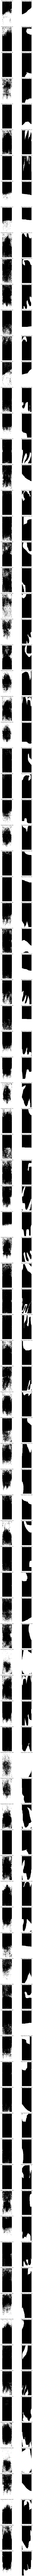

In [ ]:
get_visualizations('lr=0.001, abn_weight=0.98, model=LinearModel, upsampling_net=None', test_dataset)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


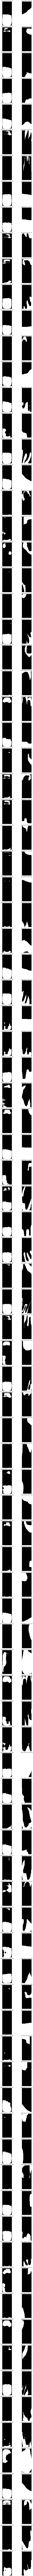

In [ ]:
get_visualizations('lr=0.001, abn_weight=0.98, model=UNET, upsampling_net=MultiLayer', test_dataset)

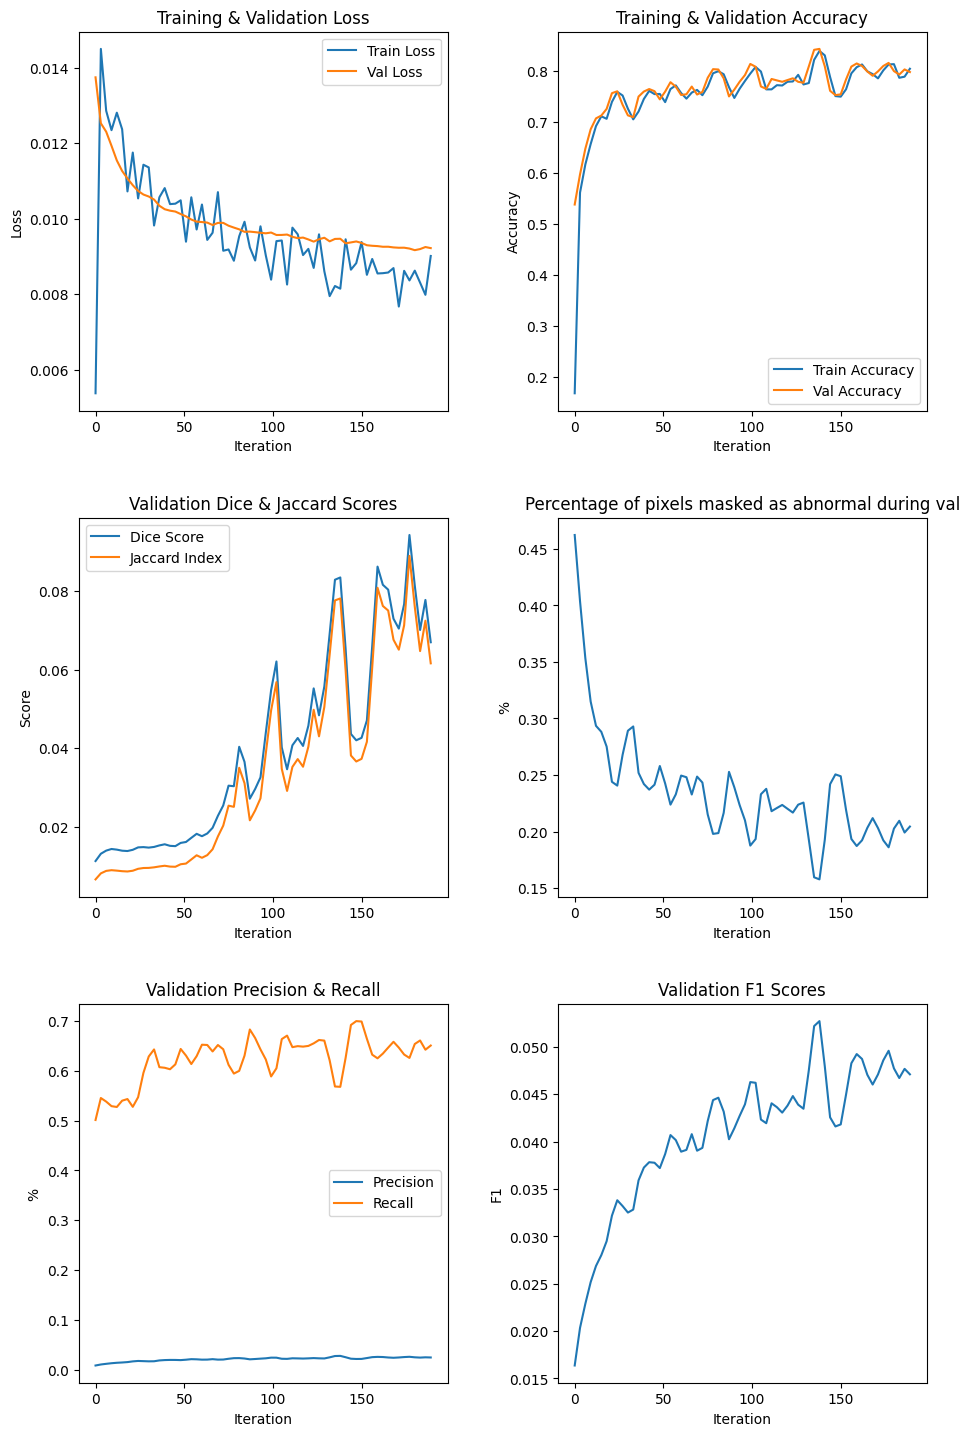

In [ ]:
solver.plot_metrics()

In [ ]:
epochs = 3
model = LinearModel()

loss_function = FocalLoss(alpha=0.99, gamma = 10)

solver = Solver(model, loss_function, train_loader, val_loader, device)
solver.train(epochs, print_every=3)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main



Epoch 0 | Iteration 0:
Training Loss = 0.03420200447241465
Training Acc = 0.16582020123799643
Val Loss = 0.04292640835046768
Val Accuracy = 0.6535426378250122

Epoch 0 | Iteration 3:
Training Loss = 0.022464369734128315
Training Acc = 0.7618672847747803
Val Loss = 0.0032338351011276245
Val Accuracy = 0.9132494330406189

Epoch 0 | Iteration 6:
Training Loss = 0.0021493012318387628
Training Acc = 0.9406527876853943
Val Loss = 0.0015980096068233252
Val Accuracy = 0.9739810824394226

Epoch 0 | Iteration 9:
Training Loss = 0.0023485003039240837
Training Acc = 0.9759810169537863
Val Loss = 0.0019065078813582659
Val Accuracy = 0.980908215045929

Epoch 0 | Iteration 12:
Training Loss = 0.0022285908926278353
Training Acc = 0.9787743091583252
Val Loss = 0.0021396141964942217
Val Accuracy = 0.9778745174407959

Epoch 0 | Iteration 15:
Training Loss = 0.00226269398505489
Training Acc = 0.9756888349850973
Val Loss = 0.0022426010109484196
Val Accuracy = 0.9759568572044373

Epoch 1 | Iteration 18:
Tr


Test Metrics:
Loss: 0.001067174831405282
Accuracy: 0.9739089608192444
Dice Score: 0.0021148298401385546
Jaccard Index: 0.0011207066709175706
Precision: 0.00894066282515937
Recall: 0.06600166251039069
F1: 0.015748073141932318
Percentage of pixels masked as abnormal: 0.02199941882126983


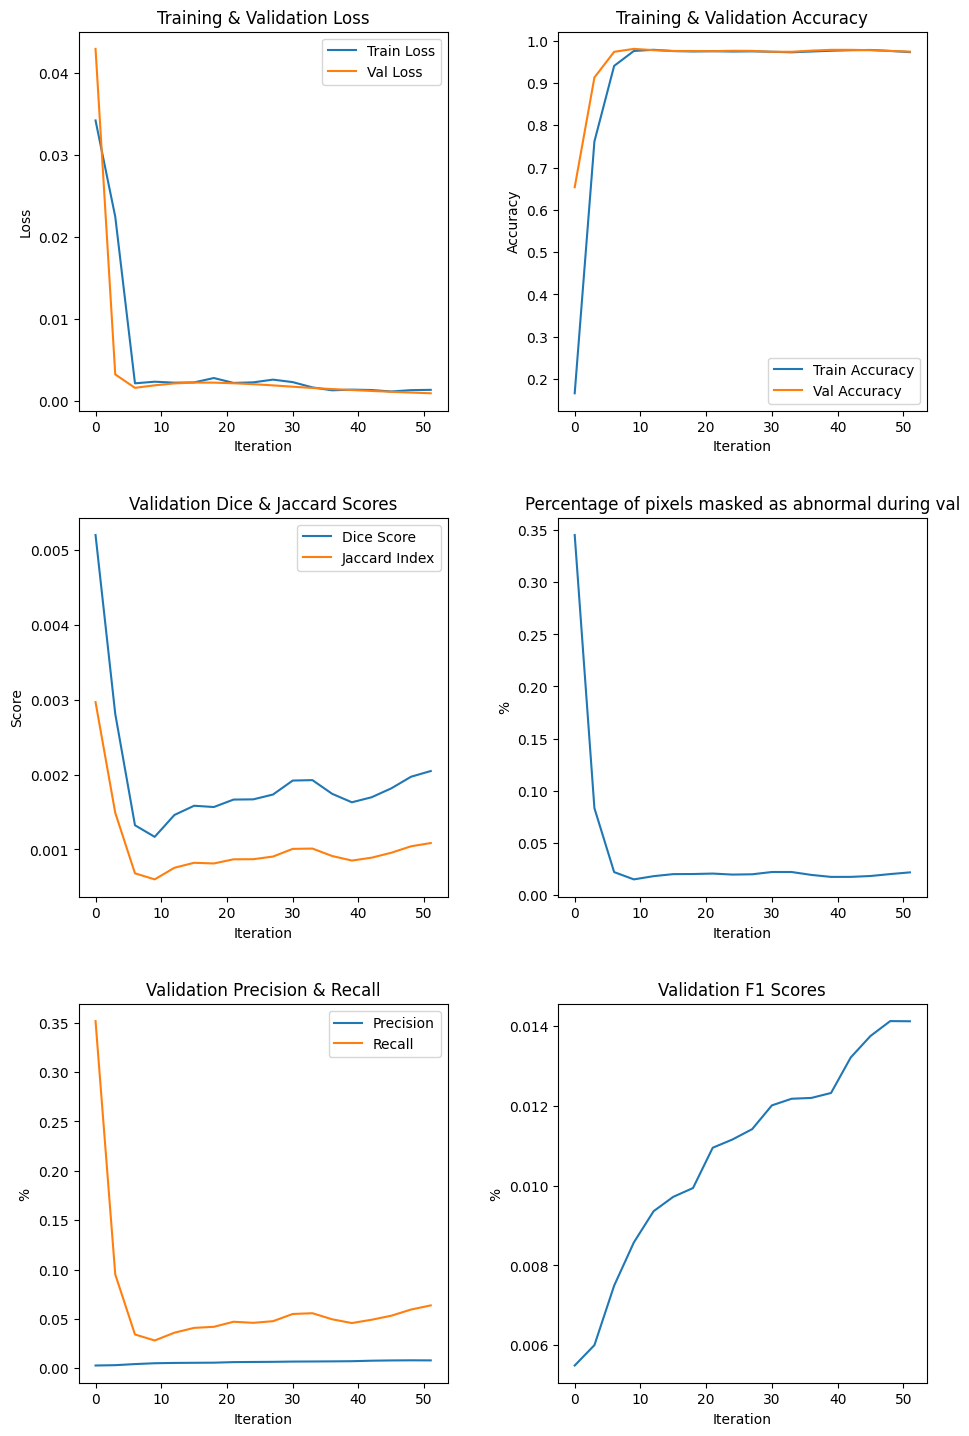

In [ ]:
solver.test(test_loader)
solver.plot_metrics()

In [ ]:
'''
# non-modularized version of the linear model code
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Assuming device, train_loader, and val_loader are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
for param in backbone.parameters():
    param.requires_grad = False

linear_decoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(384, 140 * 56),
    nn.Sigmoid(),
).to(device)

bce_loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_decoder.parameters())
writer = SummaryWriter()  # for TensorBoard logging

train_losses, train_accuracies, val_losses, val_accuracies, val_dice, val_jaccard = [], [], [], [], [], []

epochs = 1
iteration = 0

for epoch in range(epochs):
    linear_decoder.train()
    avg_train_loss = 0
    avg_train_acc = 0

    for images, masks in train_loader:
        iteration += 1

        images = images.repeat(1, 3, 1, 1).to(device)
        masks = masks.to(device)

        encoding = backbone(images)
        outputs = linear_decoder(encoding).view(-1, 1, 140, 56)
        loss = bce_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_train_loss += loss.item()

        binary_preds = (outputs > 0.5).float()
        avg_train_acc += calculate_pixel_accuracy(binary_preds, masks)

        if iteration % 40 == 0:
            avg_train_loss /= 40
            avg_train_acc /= 40
            print(f"Epoch {epoch} | Iteration {iteration}: Avg Training Loss = {avg_train_loss}")
            print(f"Epoch {epoch} | Iteration {iteration}: Avg Training Acc = {avg_train_acc}")
            #writer.add_scalar('training loss', avg_train_loss, iteration)
            train_accuracies.append(avg_train_acc)
            train_losses.append(avg_train_loss)
            avg_train_loss = 0
            avg_train_acc = 0

    # Validation phase
    linear_decoder.eval()
    avg_val_loss = 0
    avg_val_acc = 0
    dice = []
    jaccard = []
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.repeat(1, 3, 1, 1).to(device), val_masks.to(device)

            val_encoding = backbone(val_images)
            val_preds = linear_decoder(val_encoding).view(-1, 1, 140, 56)
            avg_val_loss += bce_loss(val_preds, val_masks).item()

            binary_preds = (val_preds > 0.5).float()
            avg_val_acc += calculate_pixel_accuracy(binary_preds, val_masks)

            dice.append(dice_coefficient(binary_preds, val_masks))
            jaccard.append(jaccard_index(binary_preds, val_masks))

    filtered_dice = [item for item in dice if item is not None]
    filtered_jaccard = [item for item in jaccard if item is not None]
    val_dice.append(sum(filtered_dice) / len(filtered_dice))
    val_jaccard.append(sum(filtered_jaccard) / len(filtered_jaccard))

    val_losses.append(avg_val_loss / len(val_loader))
    val_accuracies.append(avg_val_acc / len(val_loader))

    print(f"Epoch {epoch}: Avg Validation Loss = {avg_val_loss / len(val_loader)}")
'''

'\n# non-modularized version of the linear model code\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.tensorboard import SummaryWriter\n\n# Assuming device, train_loader, and val_loader are already defined\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nbackbone = torch.hub.load(\'facebookresearch/dinov2\', \'dinov2_vits14\').to(device)\nfor param in backbone.parameters():\n    param.requires_grad = False\n\nlinear_decoder = nn.Sequential(\n    nn.Flatten(),\n    nn.Linear(384, 140 * 56),\n    nn.Sigmoid(),\n).to(device)\n\nbce_loss = nn.BCEWithLogitsLoss()\noptimizer = optim.Adam(linear_decoder.parameters())\nwriter = SummaryWriter()  # for TensorBoard logging\n\ntrain_losses, train_accuracies, val_losses, val_accuracies, val_dice, val_jaccard = [], [], [], [], [], []\n\nepochs = 1\niteration = 0\n\nfor epoch in range(epochs):\n    linear_decoder.train()\n    avg_train_loss = 0\n    avg_train_acc = 0\n\n    for images, mask

In [ ]:
UNET = xval_results[f'lr={0.01}, abn_weight={0.97}, model=UNET, upsampling_net=MultiLayer']
visualize_masks(UNET, dataset='val', mode='normal', num_images=25)

NameError: ignored